In [1]:
# Python packages and utilities
import importlib
import logging
import os
import pickle
from datetime import datetime

import numpy as np
import pandas as pd
from IPython.display import HTML, display
from pickle import dump

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Update the matplotlib font configuration
plt.rcParams['font.family'] = 'Arial'  # or any other font available on your system

# mlxtend
import mlxtend
from mlxtend.plotting import plot_pca_correlation_graph

# RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Crippen, Descriptors, Draw, rdMolDescriptors
from rdkit.Chem.Draw import DrawingOptions, IPythonConsole
from rdkit.ML.Cluster import Butina

# scikit-learn
import sklearn
from sklearn import linear_model, metrics, svm
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, DotProduct, Matern, RBF, WhiteKernel
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor

# scikitplot library
import scikitplot as skplt

# seaborn
try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# own module
from pythia import classification_metrics as cmetrics
from pythia import fingerprints_generation as fp
from pythia import molecules_and_structures as ms
from pythia import plots as pltsk
from pythia import scaling
from pythia import workflow_functions as wf

# utility
%load_ext autoreload
%autoreload 2
%aimport

# Logging setup
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)

# Random seed setup
random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")


Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



This notebook apart from reproducing the results of the paper also attempts to show you how to use precalculated descriptors to train your model. In this case we used DFT descriptors, however you could use any type of descriptors you wish. It explains how to use PCA (although it is not used for the results of this paper) as well as how to get the most important features from LASSOCV. This is used in the results of the paper. Please follow step by step of feel free to skip steps you might not be interested in like PCA or LASSOCV interpretation.

# Load target data

First we read the dataset from a csv file. A csv file is a comma separated file, where each row is a data point.
pd.read_csv() is used to read the input csv file that contain the dataset. The dataset is stored in a dataframe, which is a data structure provided by the pandas library. A dataframe is a two-dimensional data structure, i.e. data is aligned in a tabular fashion in rows and columns. The dataframe can be indexed by column names.
Here, we also reformat the column names to replace spaces with underscores and make the column names all lower case. This is done to make it easier to work with the data.

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)

We have one csv with the DFT data and one with the targets (ddg)

In [3]:
data = pd.read_csv("DFTdata.csv",header=None)

In [4]:
ddg = pd.read_csv("DDG.csv",header=None)

In [5]:
ddg = ddg[0]

Here I make for you a folder to save all the models you create with this notebook

In [6]:
os.makedirs("results_reg_DFT", exist_ok=True)
os.chdir("results_reg_DFT")

# PCA Example
Here we show how you can perform PCA to reduce the features.

If you do not know what PCA is or how it works please read
https://en.wikipedia.org/wiki/Principal_component_analysis 

In [7]:
X = data
y = ddg # is not used

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

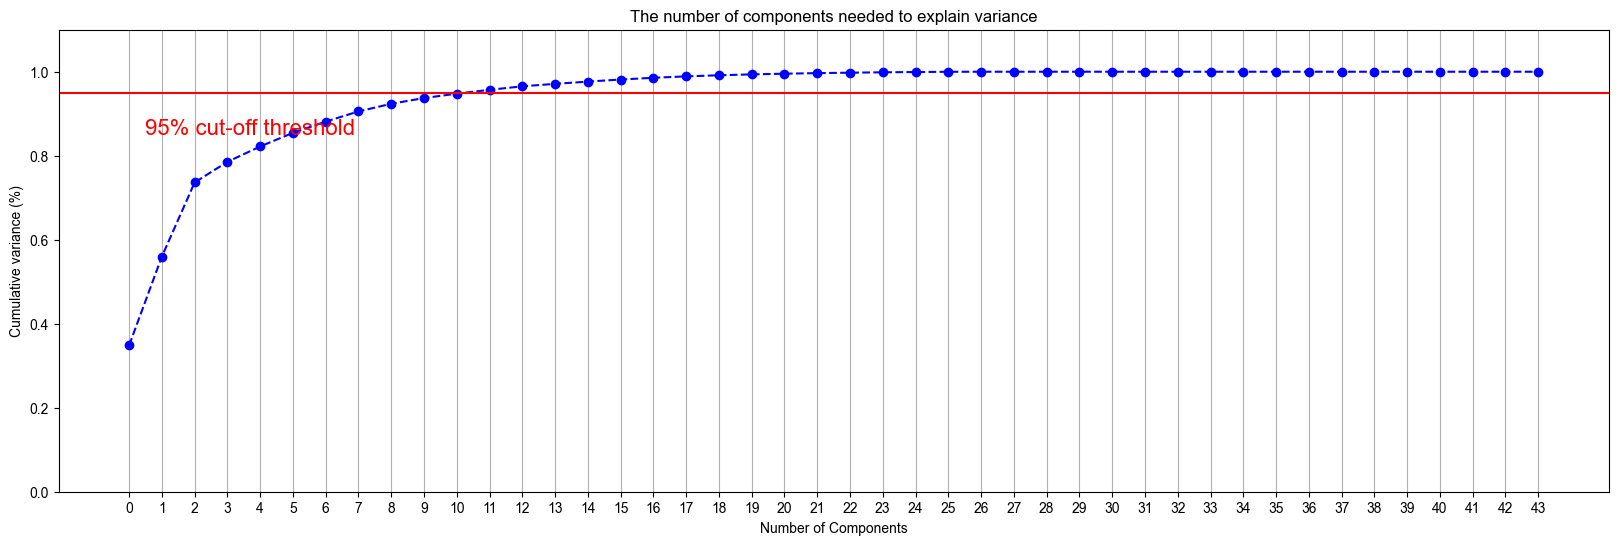

In [8]:
pca = PCA().fit(data_rescaled)
plt.rcParams["figure.figsize"] = (20,6)
fig, ax = plt.subplots()
xi = np.arange(0, 44, step=1) # change 44 according to number of features!!!
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 44, step=1)) #change here as well
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

The important descriptors are 12 according to the plot above

In [9]:
model = PCA(n_components = 0.95, whiten=True).fit(data_rescaled)
X_pc = model.transform(data_rescaled)

n_pcs= model.components_.shape[0]
print(n_pcs)

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# if your features have names, as they should, you can do the following. if not no need to remove from comments
# Name all features in order as they appear in your csv eg.
# initial_feature_names = ['HOMOsub', 'LUMOsub', 'C1', 'N1', 'Cindole', 'Dipolesub', 'L(N-C1)',
#        'B1(N-C1)', 'B5(N-C1)', 'L(N-C3)', 'B1(N-C3)', 'B5(N-C3)', 'L(N-C12)',
#        'B5(H-Cind+A2ole)', 'B5(N-C12)', 'L(H-Cindole)', 'B1(H-Cindole)',
#        'B5(H-Cindole)', 'HOMO', 'LUMO', 'TOTAL NH', 'TOTAL CN', 'TOTAL N49-H',
#        'Cl- Charge', 'TOTAL Hcharge', 'AVG H CHRG', 'DIPOLE', '49Cl NMR']
# get the names
# most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
# print(most_important_names)

# using LIST COMPREHENSION HERE AGAIN
# dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# If no names are included continue here
dic = {'PC{}'.format(i+1): most_important[i] for i in range(n_pcs)}
# build the dataframe
df = pd.DataFrame(dic.items())
df


12


,0,1
0,PC1,43
1,PC2,30
2,PC3,10
3,PC4,25
4,PC5,7
5,PC6,32
6,PC7,1
7,PC8,36
8,PC9,25
9,PC10,7


make dataframe only containing the PCA features

In [10]:
col_names = [col for col in data.columns if col in df[1].values and data[col].all()]

In [11]:
col_names

[1, 7, 10, 24, 25, 32, 36, 43]

In [12]:
data_pca = data[col_names]
print(data_pca)

       1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
..    ...   ...   ...   ...   ...   ...   ...  ..
114 -2.16  4.62 -4.49  6.16  5.77  3.59  9.33 -75
115 -1.47  6.47 -3.62  6.01  4.90  2.67  9.69 -30
116 -2.40  6.50 -3.62  6.01  4.90  2.67  9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67  9.69 -75
118 -2.16  4.62 -3.62  6.01  4.90  2.67  9.69 -75

[119 rows x 8 columns]


Now we call our classifiers 

In [13]:
# Feel free to add or remove regressors you might want (or don't) to explore, here we just offer some examples.

kfold_reg_names = ["LassoCV","KNeighborsRegressor", "DecisionTreeRegressor", "SVR",
                   "BayesianRegr", "GaussianProcessRegressor", "RandomForestRegressor"]
kfold_regressors = [
    LassoCV(random_state=random_seed, cv=10,selection='random',max_iter=1000000),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=random_seed),
    svm.SVR(), #SVR takes some time be patient if you are not, comment it out
    linear_model.BayesianRidge(n_iter=100000),
    GaussianProcessRegressor(),
    RandomForestRegressor(random_state=random_seed)]# takes some time, you can remove some options for the parameters

kfold_regressors_parameters = {
    "LassoCV":{},
    "KNeighborsRegressor": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "DecisionTreeRegressor": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "SVR": {"kernel":['linear', 'poly', 'rbf'], "degree":[2,3], "gamma":['auto','scale'], "coef0":[0,1], 'C':[100]},    
    "BayesianRegr":{'alpha_1':[1e-06, 10], 'alpha_2': [1e-06,10],'lambda_1':[1e-06,10], 'lambda_2': [1e-06,10]},
    "GaussianProcessRegressor": {},  
    "RandomForestRegressor":{'n_estimators': [10,20],'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'],'max_depth': [3, 4, 5, 7, 10],
    'max_features': ['auto','sqrt','log2'],'bootstrap': [True, False],'warm_start': [True, False]}
}

And finally we train the model based on the features that PCA selected!

In [14]:
%%capture
wf.kfold_test_regressor_with_optimization(data_pca,ddg, kfold_regressors, kfold_regressors_parameters, scale=False, cv=5, n_repeats=10, rgs_names=kfold_reg_names)

Features: Int64Index([1, 7, 10, 24, 25, 32, 36, 43], dtype='int64')
Starting regression

-----
Begin LassoCV
-----

Directory LassoCV already exists will be overwritten
----- LassoCV: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	name: LassoCV parameters: {}

	----- Predicting using: LassoCV -----
	Xtrain:        1     7     10    24    25    32     36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59   9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65   9.20 -30
4   -1.47  6.5


	score (LassoCV): 0.4920082409329546
----- LassoCV: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	name: LassoCV parameters: {}

	----- Predicting using: LassoCV -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
5   -2.40  6.62 -4.55  8.45  7.03  2.73  9.14 -30
..    ... 


	score (LassoCV): 0.17437236939670508
----- LassoCV: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	name: LassoCV parameters: {}

	----- Predicting using: LassoCV -----
	Xtrain:        1     7     10    24    25    32     36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59   9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59   9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65   9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65   9.20 -30
6   -1.47  6.65 -4.48  9.03  9.80  3.66  

	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}

	----- Predicting using: KNeighborsRegressor -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
..    ...   ...   ...   ...   ...   ...   ...  ..
114 -2.16  4.62 -4.49  6.16  5.77  3.59  9.33 -75
115 -1.47  6.47 -3.62  6.01  4.90  2.67  9.69 -30
116 -2.40  6.50 -3.62  6.01  4.90  2.67  9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67  9.69 -75
118 -2.16  4.62 -3.62  6.01  4.90  2.67  9.69 -75

[107 rows x 8 columns]
	Xtest:       1     7     10     24    25    32     36  43
6  -1.47  6.65 -4.48   9.03  9.80  3.66  10.26 -30
18 -2.78  6.50 -4.58   8.10  7.21  3.04   9.12 -30
21 -2.34  6.51 -4.58   8.10  7.21  3.04   9.12 -30
33 -2.36  4.61 -2.11  


	score (KNeighborsRegressor): 0.022967716291230844
----- KNeighborsRegressor: Fold 5 -----
[0, 8, 11, 28, 53, 64, 73, 80, 86, 90, 104, 108]
	Train indx [  1   2   3   4   5   6   7   9  10  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  54  55  56  57  58
  59  60  61  62  63  65  66  67  68  69  70  71  72  74  75  76  77  78
  79  81  82  83  84  85  87  88  89  91  92  93  94  95  96  97  98  99
 100 101 102 103 105 106 107 109 110 111 112 113 114 115 116 117 118]
	Test indx: [  0   8  11  28  53  64  73  80  86  90 104 108]
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}

	----- Predicting using: KNeighborsRegressor -----
	Xtrain:        1     7     10    24    25    32    36  43
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.4

	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}

	----- Predicting using: KNeighborsRegressor -----
	Xtrain:        1     7     10    24    25    32     36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59   9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59   9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65   9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65   9.20 -30
6   -1.47  6.65 -4.48  9.03  9.80  3.66  10.26 -30
..    ...   ...   ...   ...   ...   ...    ...  ..
113 -2.17  6.57 -4.49  6.16  5.77  3.59   9.33 -75
114 -2.16  4.62 -4.49  6.16  5.77  3.59   9.33 -75
115 -1.47  6.47 -3.62  6.01  4.90  2.67   9.69 -30
116 -2.40  6.50 -3.62  6.01  4.90  2.67   9.69 -30
118 -2.16  4.62 -3.62  6.01  4.90  2.67   9.69 -75

[107 rows x 8 columns]
	Xtest:        1     7     10     24    25    32     36  43
4   -1.47  6.59 -4.55   8.45  7.03  2.73   9.14 -30
5   -2.40  6.62 -4.55   8.45  7.03  2.73   9.14 -30
20  -2.57  6.49 -4.58   8.10  7.21  3.04   9.12 -30
34  -1


	score (DecisionTreeRegressor): 0.7808163369123425
----- DecisionTreeRegressor: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}

	----- Predicting using: DecisionTreeRegressor -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -

	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}

	----- Predicting using: DecisionTreeRegressor -----
	Xtrain:        1     7     10    24    25    32    36  43
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
5   -2.40  6.62 -4.55  8.45  7.03  2.73  9.14 -30
..    ...   ...   ...   ...   ...   ...   ...  ..
114 -2.16  4.62 -4.49  6.16  5.77  3.59  9.33 -75
115 -1.47  6.47 -3.62  6.01  4.90  2.67  9.69 -30
116 -2.40  6.50 -3.62  6.01  4.90  2.67  9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67  9.69 -75
118 -2.16  4.62 -3.62  6.01  4.90  2.67  9.69 -75

[107 rows x 8 columns]
	Xtest:        1     7     10     24    25    32    36  43
0   -1.47  6.47 -4.49   6.16  5.77  3.59  9.33 -30
8   -1.47  6.47 -4.58   8.10  7.21  3.04  9.12 -30
11  -1.58  6.48 -4.58   8.10  7.21  3.04  9.12 -30
28  -2.08  6.51 -4.58   8


	score (DecisionTreeRegressor): 0.346589992954923
----- DecisionTreeRegressor: Fold 9 -----
[17, 32, 38, 54, 58, 62, 74, 75, 91, 96, 100]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55  56  57
  59  60  61  63  64  65  66  67  68  69  70  71  72  73  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  92  93  94  95  97  98  99
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 17  32  38  54  58  62  74  75  91  96 100]
	name: DecisionTreeRegressor parameters: {'max_depth': [2, 3, 4, 5, 7, 10]}

	----- Predicting using: DecisionTreeRegressor -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.

	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}

	----- Predicting using: SVR -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
..    ...   ...   ...   ...   ...   ...   ...  ..
112 -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
113 -2.17  6.57 -4.49  6.16  5.77  3.59  9.33 -75
114 -2.16  4.62 -4.49  6.16  5.77  3.59  9.33 -75
115 -1.47  6.47 -3.62  6.01  4.90  2.67  9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67  9.69 -75

[107 rows x 8 columns]
	Xtest:        1     7     10     24    25    32     36  43
10  -1.71  6.49 -4.58   8.10  7.21  3.04   9.12 -30
13  -1.55  6.52 -4.58   8.10  7.21  3.04   9.12 -30
29  -2.75  6.49 -4.58   8.10  7


	score (SVR): -0.15760187939840153
----- SVR: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}

	----- Predicting using: SVR -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -

	name: SVR parameters: {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3], 'gamma': ['auto', 'scale'], 'coef0': [0, 1], 'C': [100]}

	----- Predicting using: SVR -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
..    ...   ...   ...   ...   ...   ...   ...  ..
114 -2.16  4.62 -4.49  6.16  5.77  3.59  9.33 -75
115 -1.47  6.47 -3.62  6.01  4.90  2.67  9.69 -30
116 -2.40  6.50 -3.62  6.01  4.90  2.67  9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67  9.69 -75
118 -2.16  4.62 -3.62  6.01  4.90  2.67  9.69 -75

[108 rows x 8 columns]
	Xtest:        1     7     10     24    25    32     36  43
17  -2.54  6.50 -4.58   8.10  7.21  3.04   9.12 -30
32  -2.18  4.61 -2.11  11.42  5.61  2.55  10.75 -75
38  -3.53  6.15 -2.11  11.42  5


	score (BayesianRegr): -0.19433036338717313
----- BayesianRegr: Fold 3 -----
[7, 22, 31, 51, 66, 69, 72, 78, 88, 101, 106, 111]
	Train indx [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  67  68  70  71  73  74  75  76  77  79
  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98
  99 100 102 103 104 105 107 108 109 110 112 113 114 115 116 117 118]
	Test indx: [  7  22  31  51  66  69  72  78  88 101 106 111]
	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}

	----- Predicting using: BayesianRegr -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57

	name: BayesianRegr parameters: {'alpha_1': [1e-06, 10], 'alpha_2': [1e-06, 10], 'lambda_1': [1e-06, 10], 'lambda_2': [1e-06, 10]}

	----- Predicting using: BayesianRegr -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
..    ...   ...   ...   ...   ...   ...   ...  ..
113 -2.17  6.57 -4.49  6.16  5.77  3.59  9.33 -75
114 -2.16  4.62 -4.49  6.16  5.77  3.59  9.33 -75
116 -2.40  6.50 -3.62  6.01  4.90  2.67  9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67  9.69 -75
118 -2.16  4.62 -3.62  6.01  4.90  2.67  9.69 -75

[107 rows x 8 columns]
	Xtest:        1     7     10     24    25    32     36  43
14  -2.13  6.49 -4.58   8.10  7.21  3.04   9.12 -30
19  -3.11  6.47 -4.58   8.10  7.21  3.04   9.12 -30
27  -2.02  6.47 -4.58   8.1


	score (BayesianRegr): -0.22275592056660476
The average scores are: 2.375792621339541, and the std scores are: 0.618845753262006

-----
Begin GaussianProcessRegressor
-----

Directory GaussianProcessRegressor already exists will be overwritten
----- GaussianProcessRegressor: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	name: GaussianProcessRegressor parameters: {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        1     7     10    24    25    32 

	name: GaussianProcessRegressor parameters: {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
..    ...   ...   ...   ...   ...   ...   ...  ..
114 -2.16  4.62 -4.49  6.16  5.77  3.59  9.33 -75
115 -1.47  6.47 -3.62  6.01  4.90  2.67  9.69 -30
116 -2.40  6.50 -3.62  6.01  4.90  2.67  9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67  9.69 -75
118 -2.16  4.62 -3.62  6.01  4.90  2.67  9.69 -75

[107 rows x 8 columns]
	Xtest:        1     7     10     24    25    32     36  43
7   -2.40  6.68 -4.48   9.03  9.80  3.66  10.26 -30
22  -2.64  6.48 -4.58   8.10  7.21  3.04   9.12 -30
31  -2.16  4.62 -2.11  11.42  5.61  2.55  10.75 -75
51  -1.47  6.47 -4.58   8.10  7.21  3.04   9.12


	score (GaussianProcessRegressor): -23456.71259908593
----- GaussianProcessRegressor: Fold 7 -----
[15, 16, 24, 45, 48, 63, 68, 76, 82, 87, 89, 113]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  17  18  19
  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  46  47  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  66  67  69  70  71  72  73  74  75  77  78  79
  80  81  83  84  85  86  88  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 114 115 116 117 118]
	Test indx: [ 15  16  24  45  48  63  68  76  82  87  89 113]
	name: GaussianProcessRegressor parameters: {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57 

	name: RandomForestRegressor parameters: {'n_estimators': [10, 20], 'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'], 'max_depth': [3, 4, 5, 7, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False], 'warm_start': [True, False]}

	----- Predicting using: RandomForestRegressor -----
	Xtrain:        1     7     10    24    25    32     36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59   9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65   9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73   9.14 -30
5   -2.40  6.62 -4.55  8.45  7.03  2.73   9.14 -30
6   -1.47  6.65 -4.48  9.03  9.80  3.66  10.26 -30
..    ...   ...   ...   ...   ...   ...    ...  ..
113 -2.17  6.57 -4.49  6.16  5.77  3.59   9.33 -75
115 -1.47  6.47 -3.62  6.01  4.90  2.67   9.69 -30
116 -2.40  6.50 -3.62  6.01  4.90  2.67   9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67   9.69 -75
118 -2.16  4.62 -3.62  6.01  4.90  2.67   9.69 -75

[107 rows x 8 columns]
	Xtest:        1     7    

	name: RandomForestRegressor parameters: {'n_estimators': [10, 20], 'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'], 'max_depth': [3, 4, 5, 7, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False], 'warm_start': [True, False]}

	----- Predicting using: RandomForestRegressor -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
..    ...   ...   ...   ...   ...   ...   ...  ..
114 -2.16  4.62 -4.49  6.16  5.77  3.59  9.33 -75
115 -1.47  6.47 -3.62  6.01  4.90  2.67  9.69 -30
116 -2.40  6.50 -3.62  6.01  4.90  2.67  9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67  9.69 -75
118 -2.16  4.62 -3.62  6.01  4.90  2.67  9.69 -75

[107 rows x 8 columns]
	Xtest:        1     7     10     24  


	----- Predicting using: RandomForestRegressor -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
..    ...   ...   ...   ...   ...   ...   ...  ..
113 -2.17  6.57 -4.49  6.16  5.77  3.59  9.33 -75
114 -2.16  4.62 -4.49  6.16  5.77  3.59  9.33 -75
116 -2.40  6.50 -3.62  6.01  4.90  2.67  9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67  9.69 -75
118 -2.16  4.62 -3.62  6.01  4.90  2.67  9.69 -75

[107 rows x 8 columns]
	Xtest:        1     7     10     24    25    32     36  43
14  -2.13  6.49 -4.58   8.10  7.21  3.04   9.12 -30
19  -3.11  6.47 -4.58   8.10  7.21  3.04   9.12 -30
27  -2.02  6.47 -4.58   8.10  7.21  3.04   9.12 -30
35  -2.17  6.57 -2.11  11.42  5.61  2.55  10.75 -75
43  -1.28  6.61 -2.11  11.42  5.61  2.55  10.


	----- Predicting using: RandomForestRegressor -----
	Xtrain:        1     7     10    24    25    32    36  43
0   -1.47  6.47 -4.49  6.16  5.77  3.59  9.33 -30
1   -2.40  6.50 -4.49  6.16  5.77  3.59  9.33 -30
2   -1.47  6.53 -4.55  8.57  6.72  2.65  9.20 -30
3   -2.40  6.56 -4.55  8.57  6.72  2.65  9.20 -30
4   -1.47  6.59 -4.55  8.45  7.03  2.73  9.14 -30
..    ...   ...   ...   ...   ...   ...   ...  ..
114 -2.16  4.62 -4.49  6.16  5.77  3.59  9.33 -75
115 -1.47  6.47 -3.62  6.01  4.90  2.67  9.69 -30
116 -2.40  6.50 -3.62  6.01  4.90  2.67  9.69 -30
117 -2.17  6.57 -3.62  6.01  4.90  2.67  9.69 -75
118 -2.16  4.62 -3.62  6.01  4.90  2.67  9.69 -75

[108 rows x 8 columns]
	Xtest:        1     7     10     24    25    32     36  43
17  -2.54  6.50 -4.58   8.10  7.21  3.04   9.12 -30
32  -2.18  4.61 -2.11  11.42  5.61  2.55  10.75 -75
38  -3.53  6.15 -2.11  11.42  5.61  2.55  10.75 -75
54  -1.47  6.47 -4.85   8.24  6.91  3.11   9.11 -30
58  -1.47  6.47 -4.55   8.45  7.03  2.73   9.

In [15]:
directory_names = wf.directory_names(kfold_reg_names)

In [16]:
data = wf.build_data_from_directory_regr(directory_names[0], max_folds=10)

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv



-----
Analyzing predictions for model LassoCV
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.38325766905431025, MAE: 1.7317363456100787, MSE: 4.984190348713983,R2: 0.38323585020290163
-----
/Users/matina/Desktop/PythiaChem/pythia/workflow_functions.py:1462: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()

-----
Analyzing predictions for model KNeighborsRegressor
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.5284965311291104, MAE: 1.4417810491015404, MSE: 3.8674656777837666,R2: 0.5214239397491669
-----
/Users/matina/Desktop/PythiaChem/pythia/workflow_functions.py:1462: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.sh

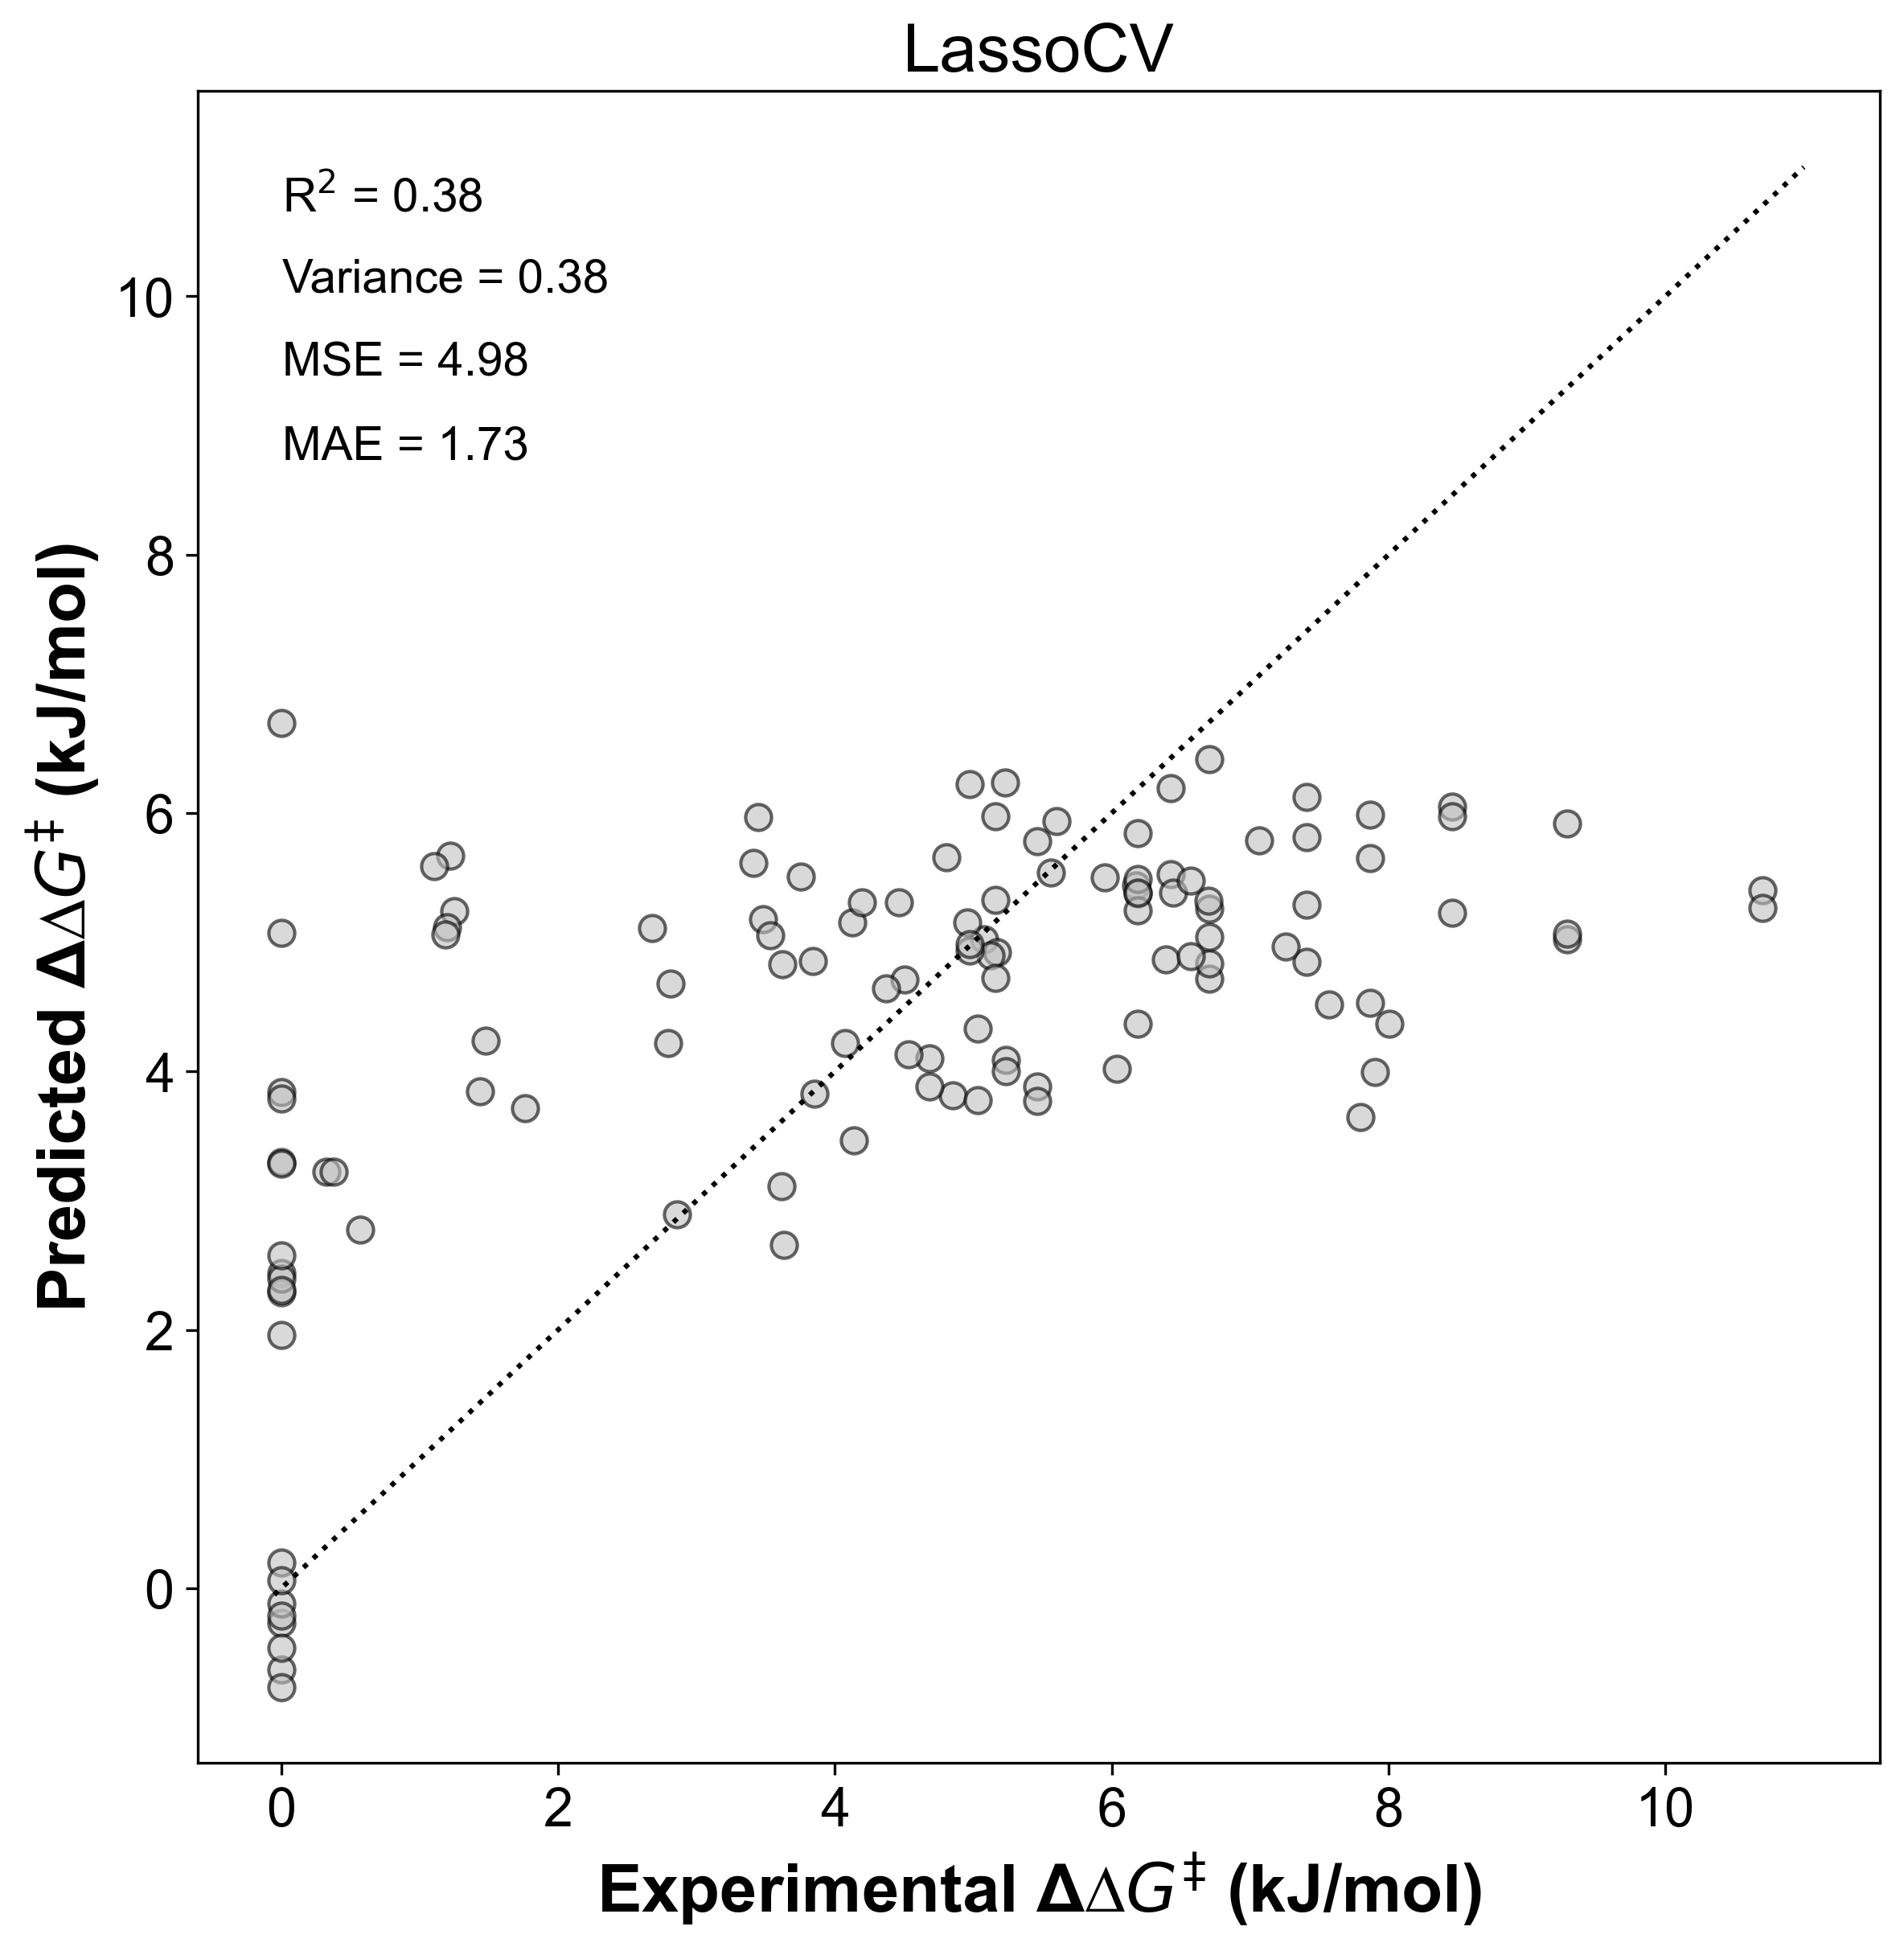

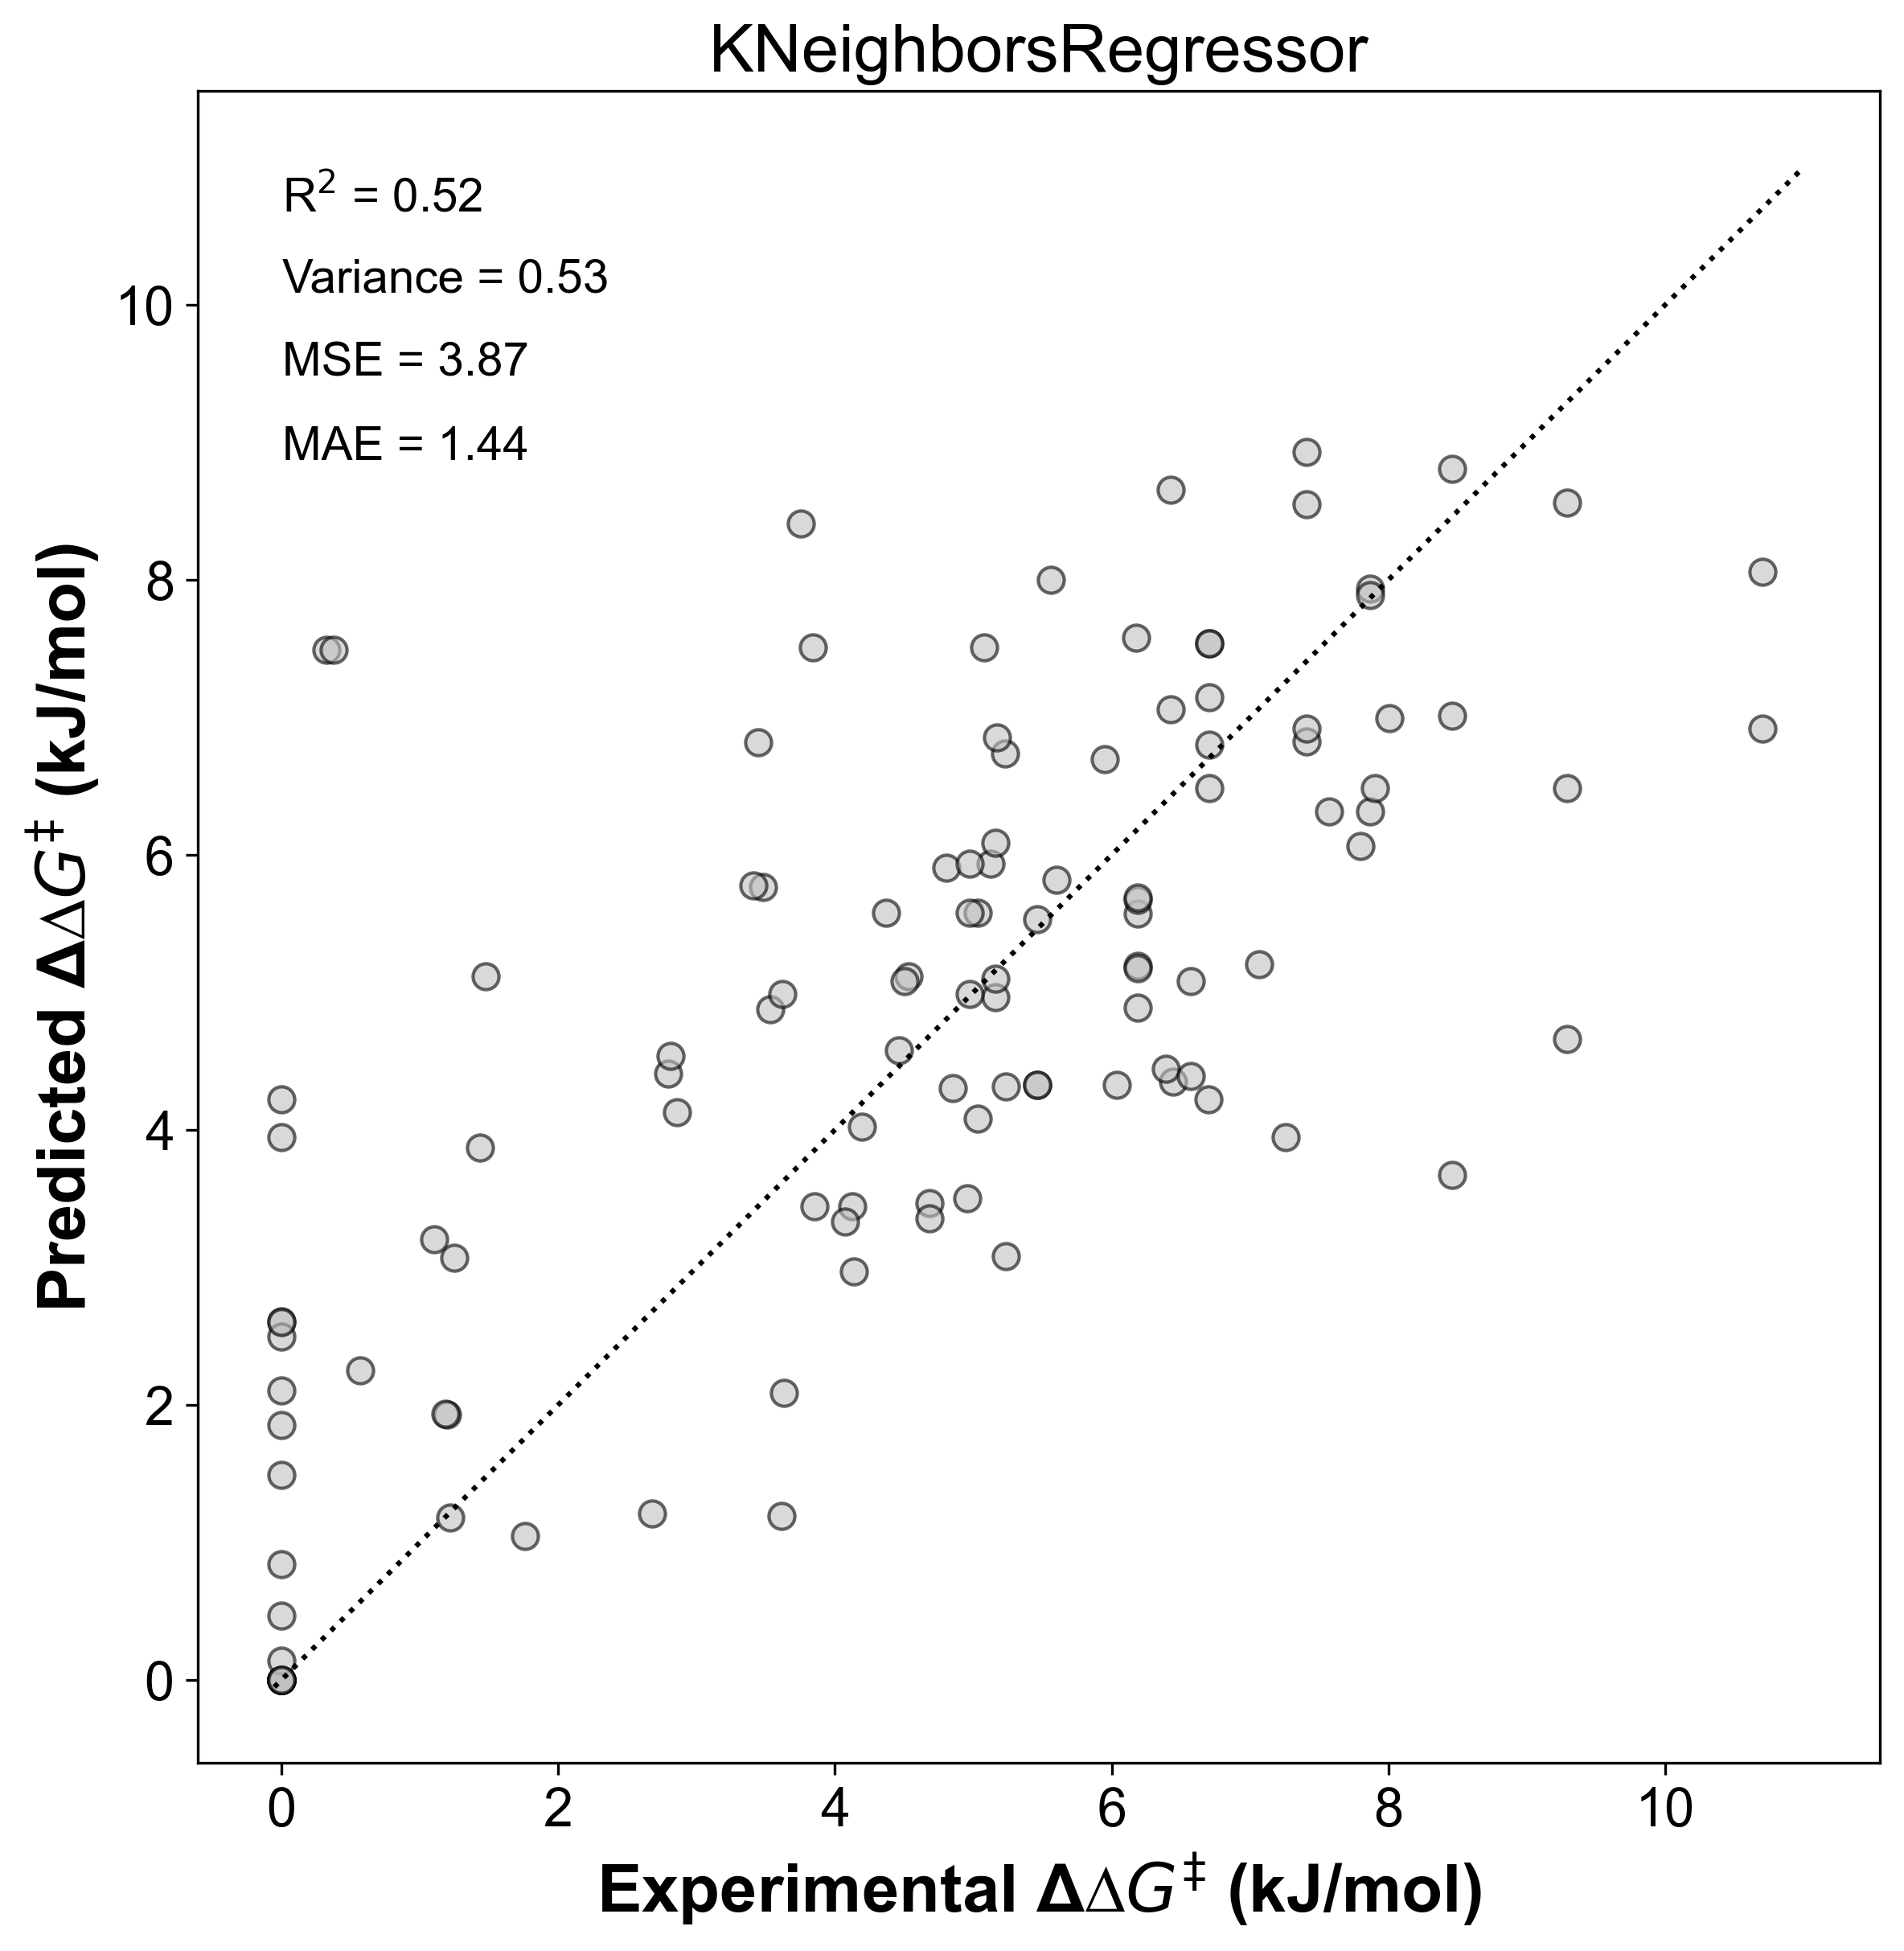

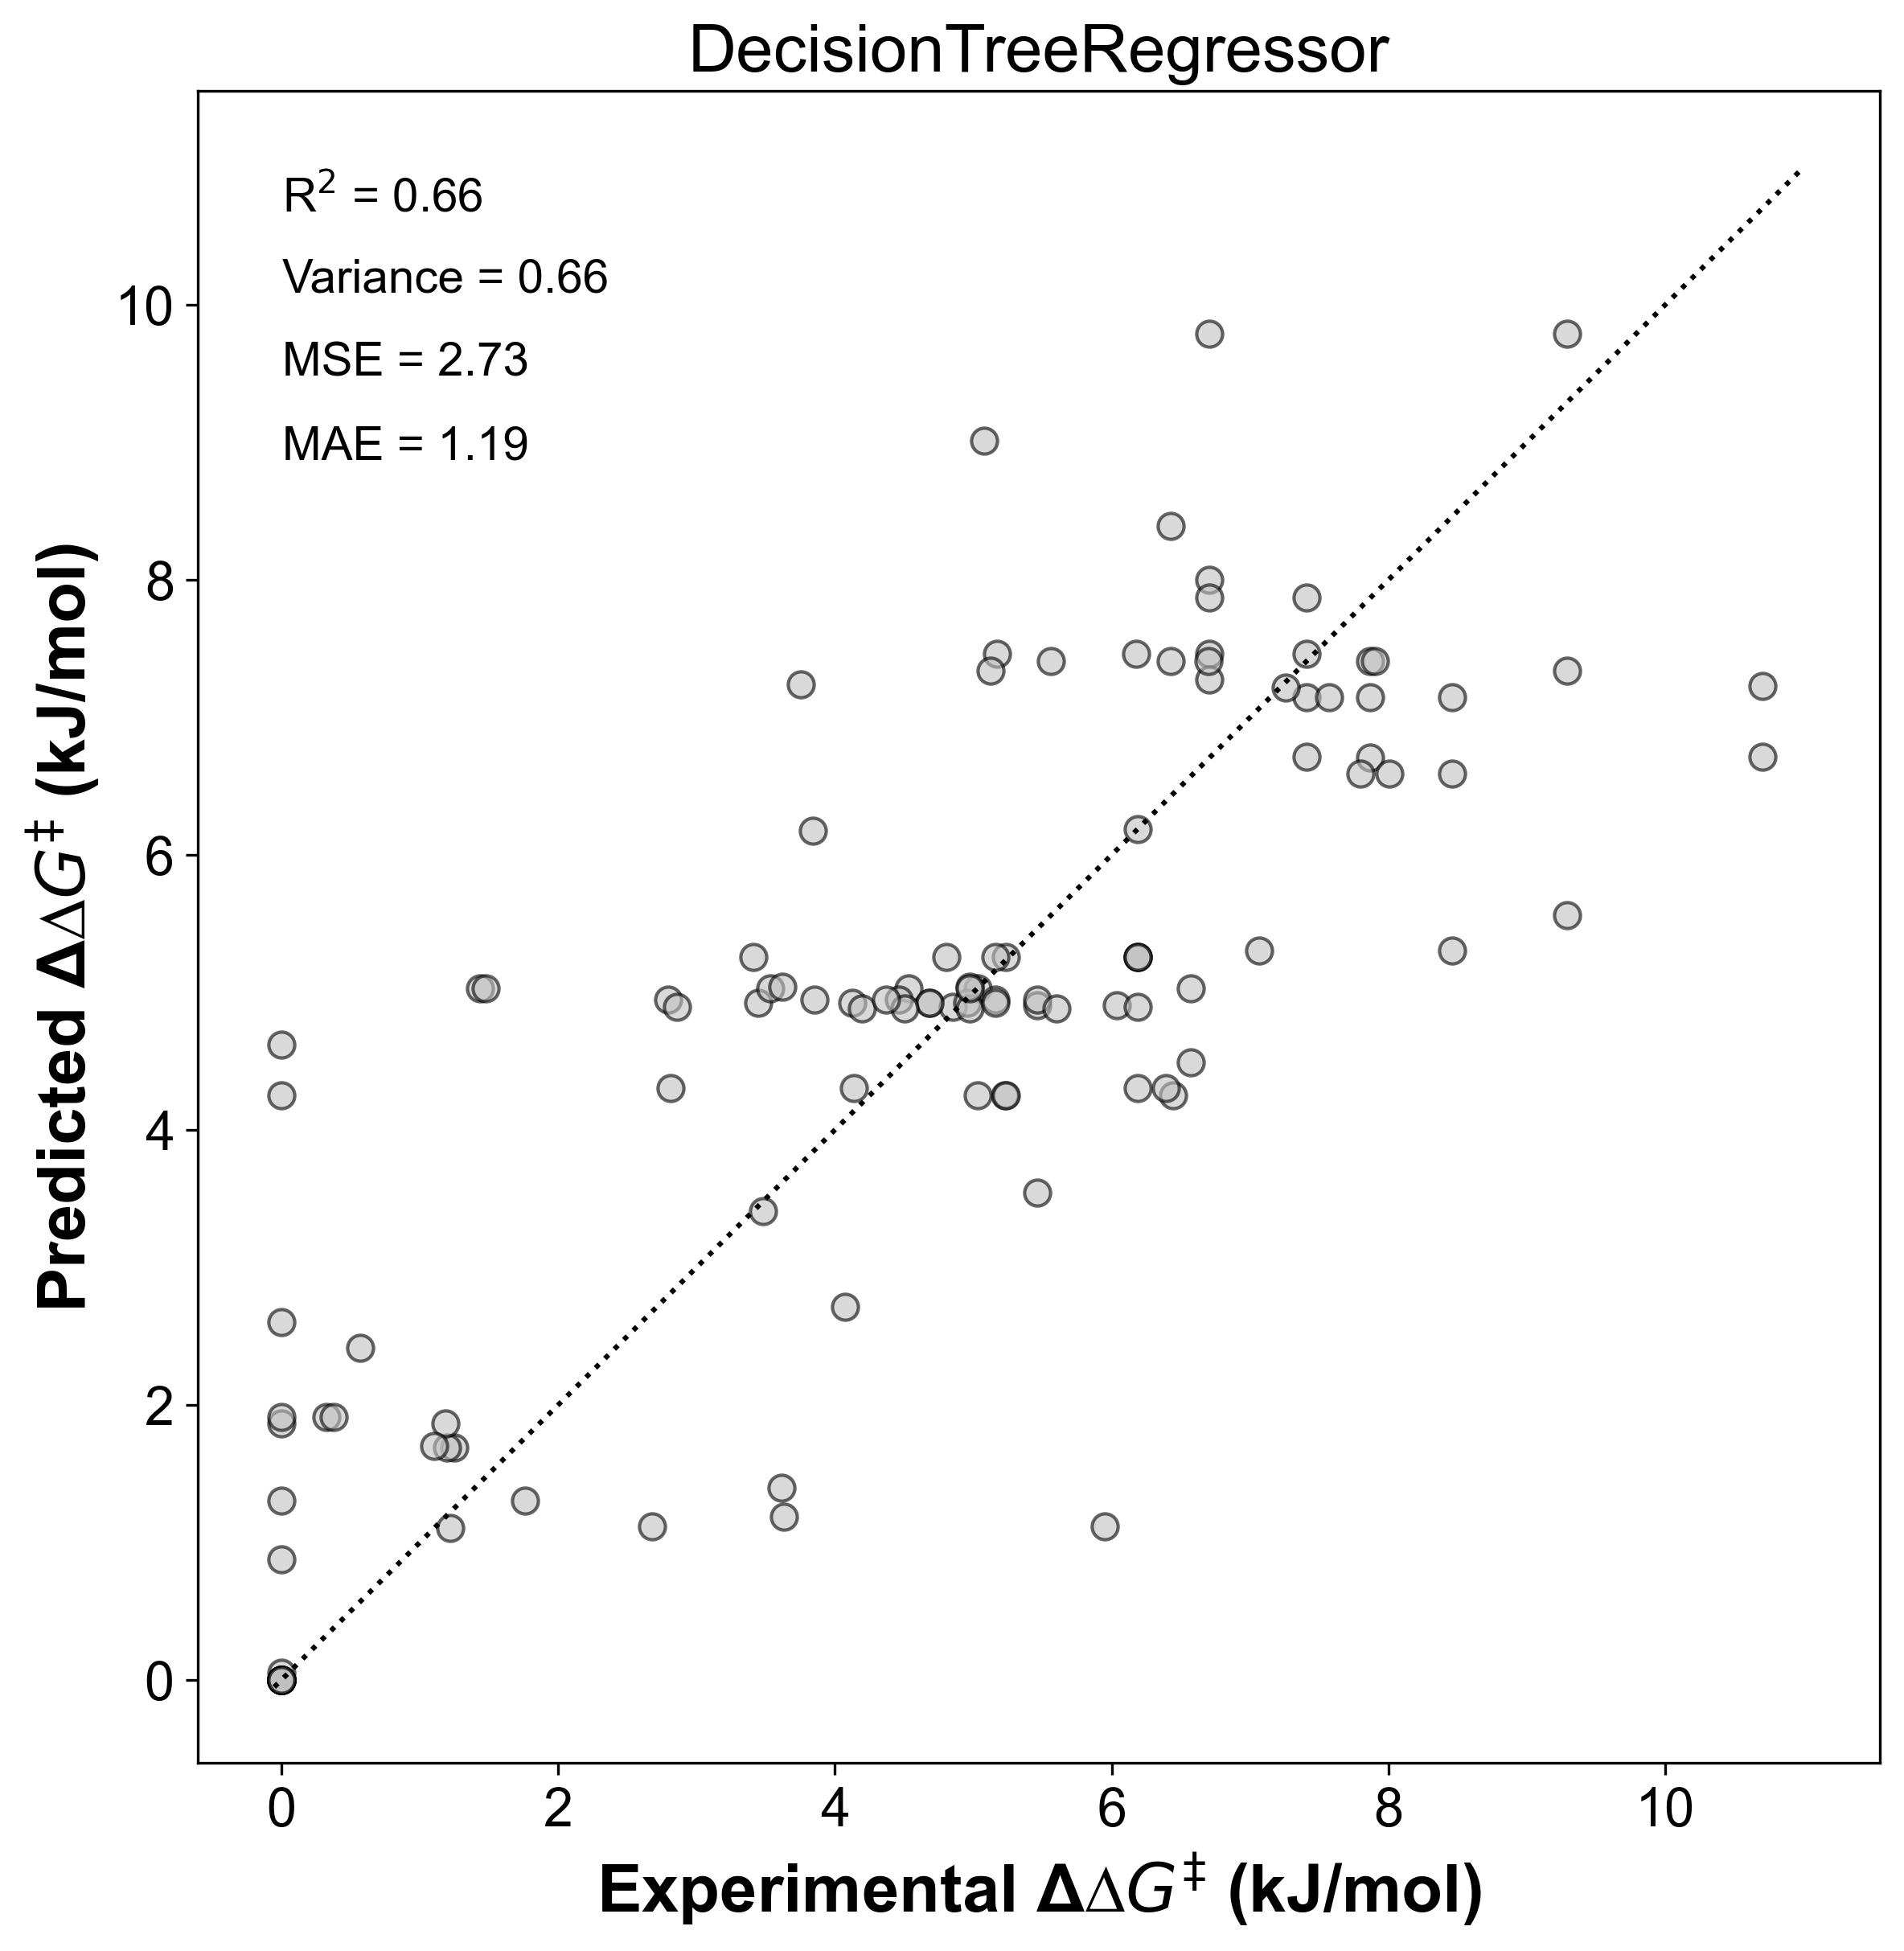

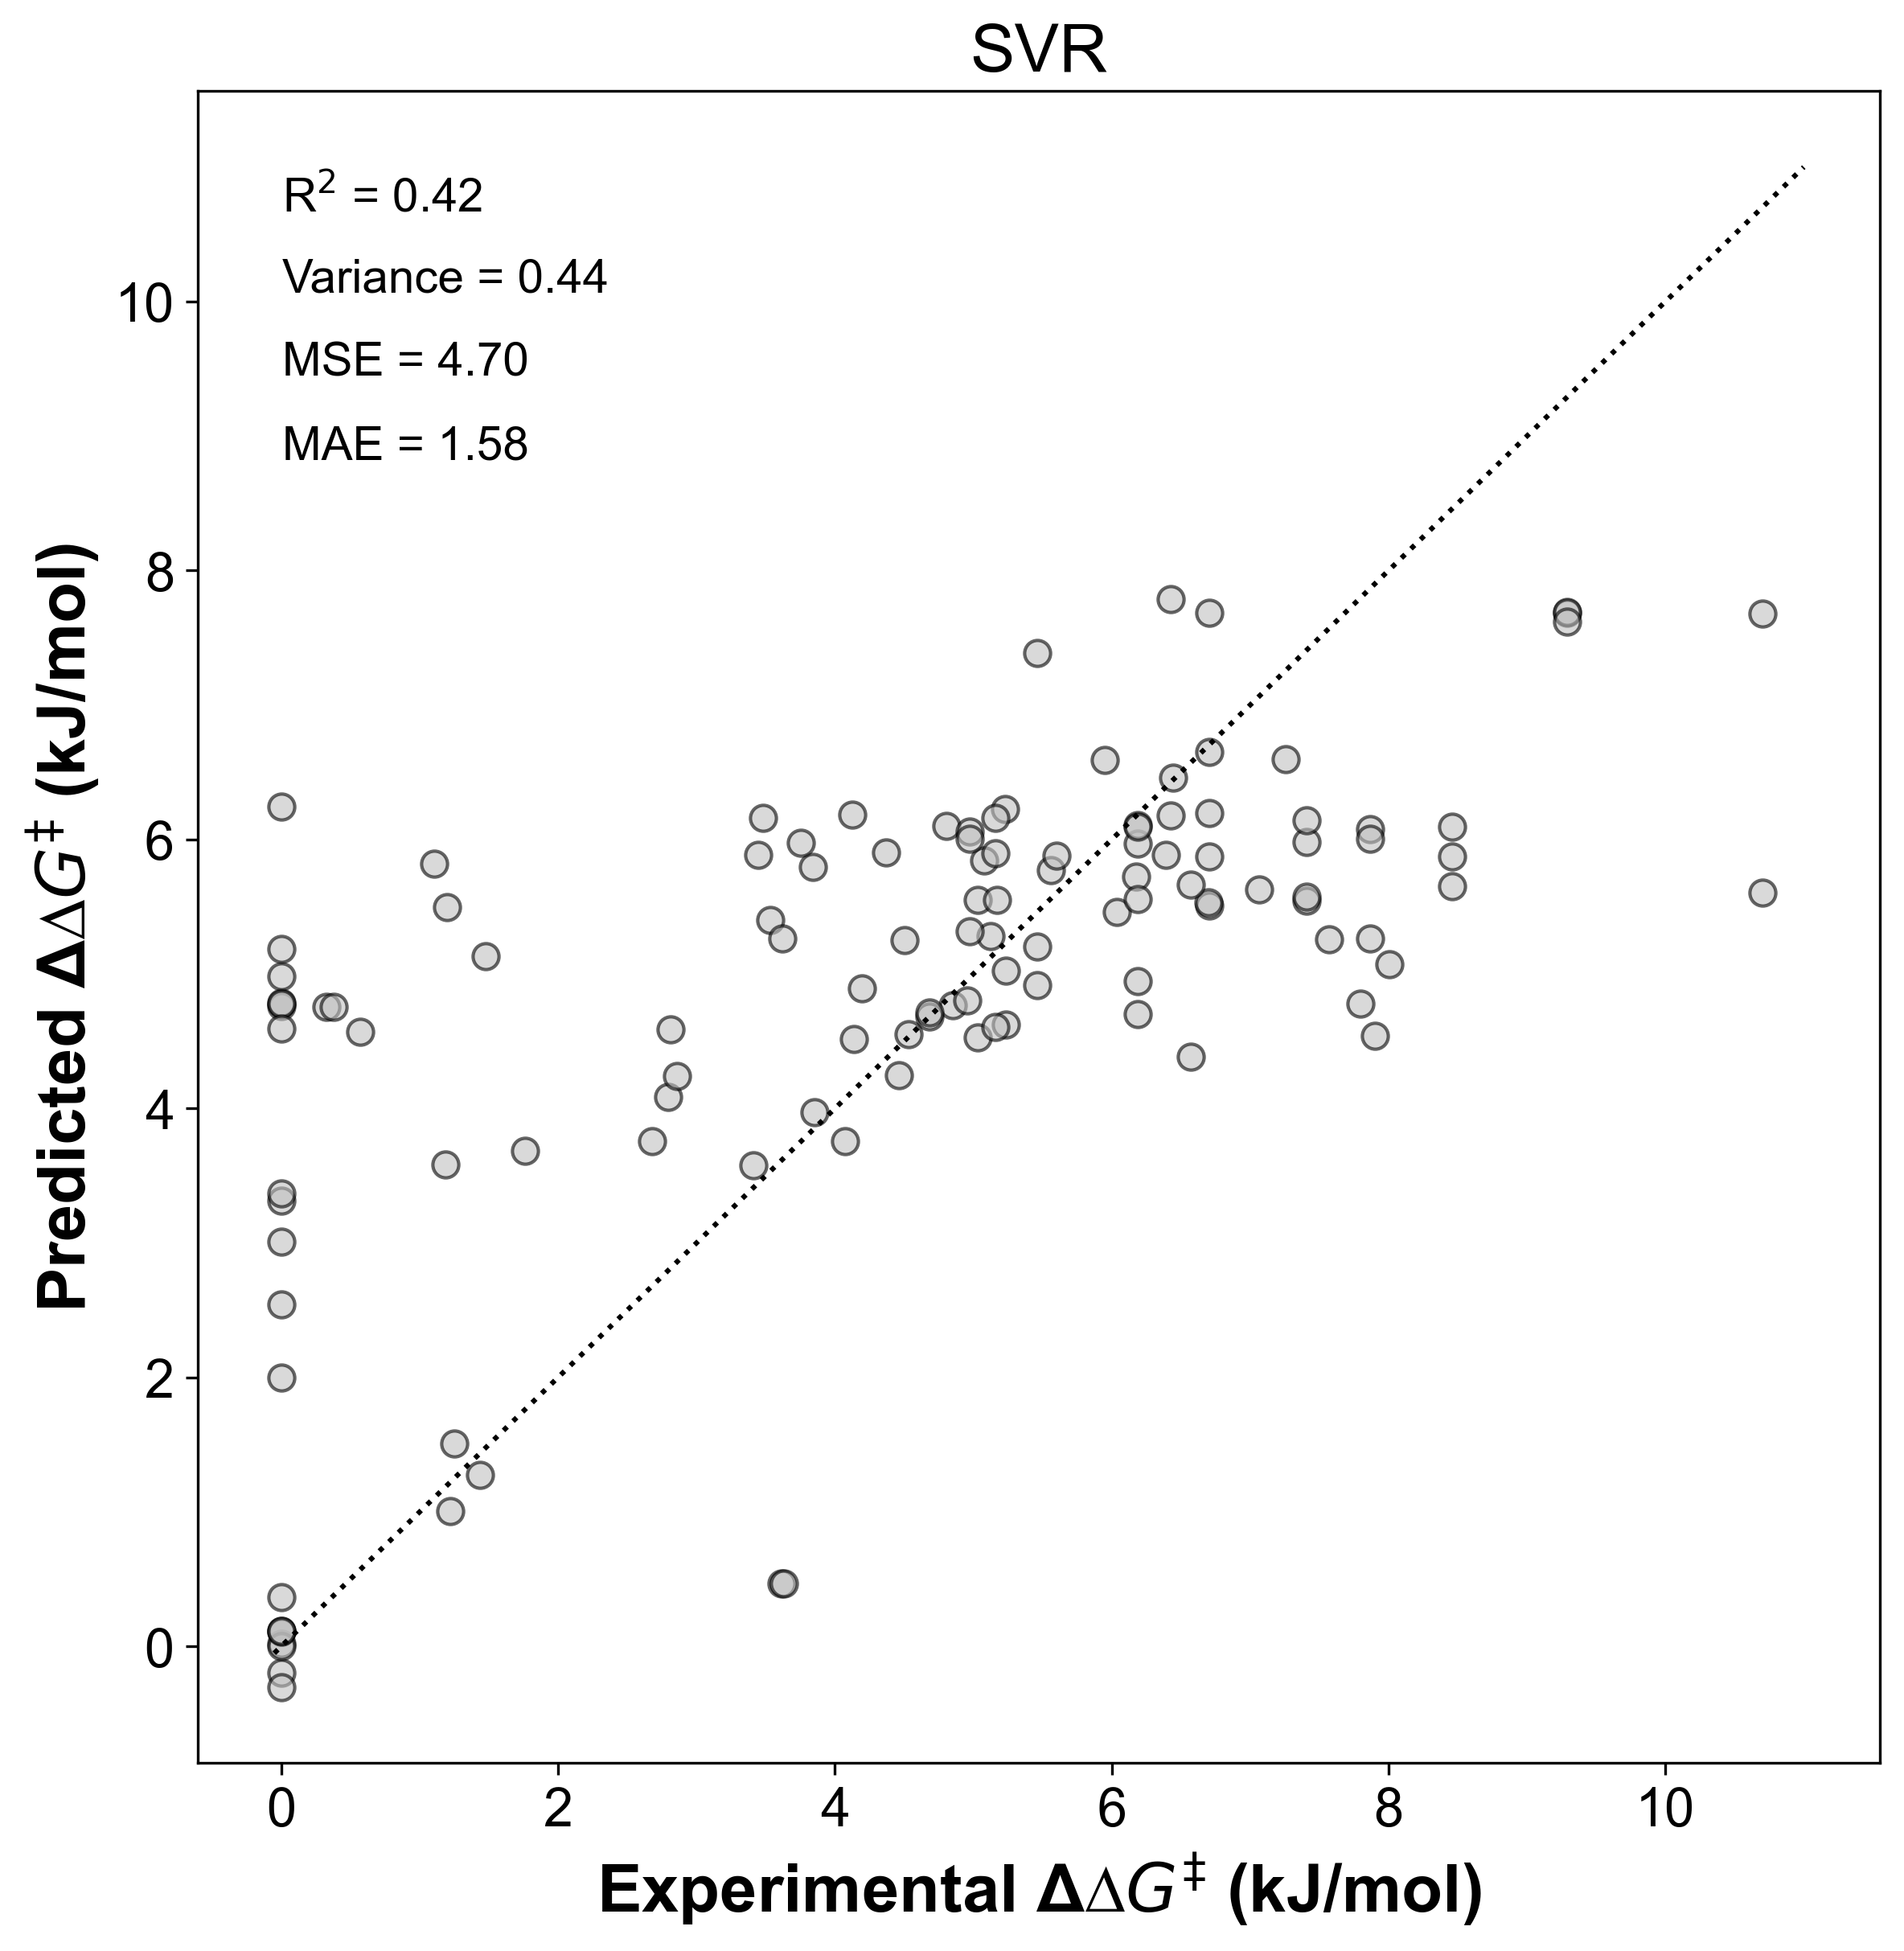

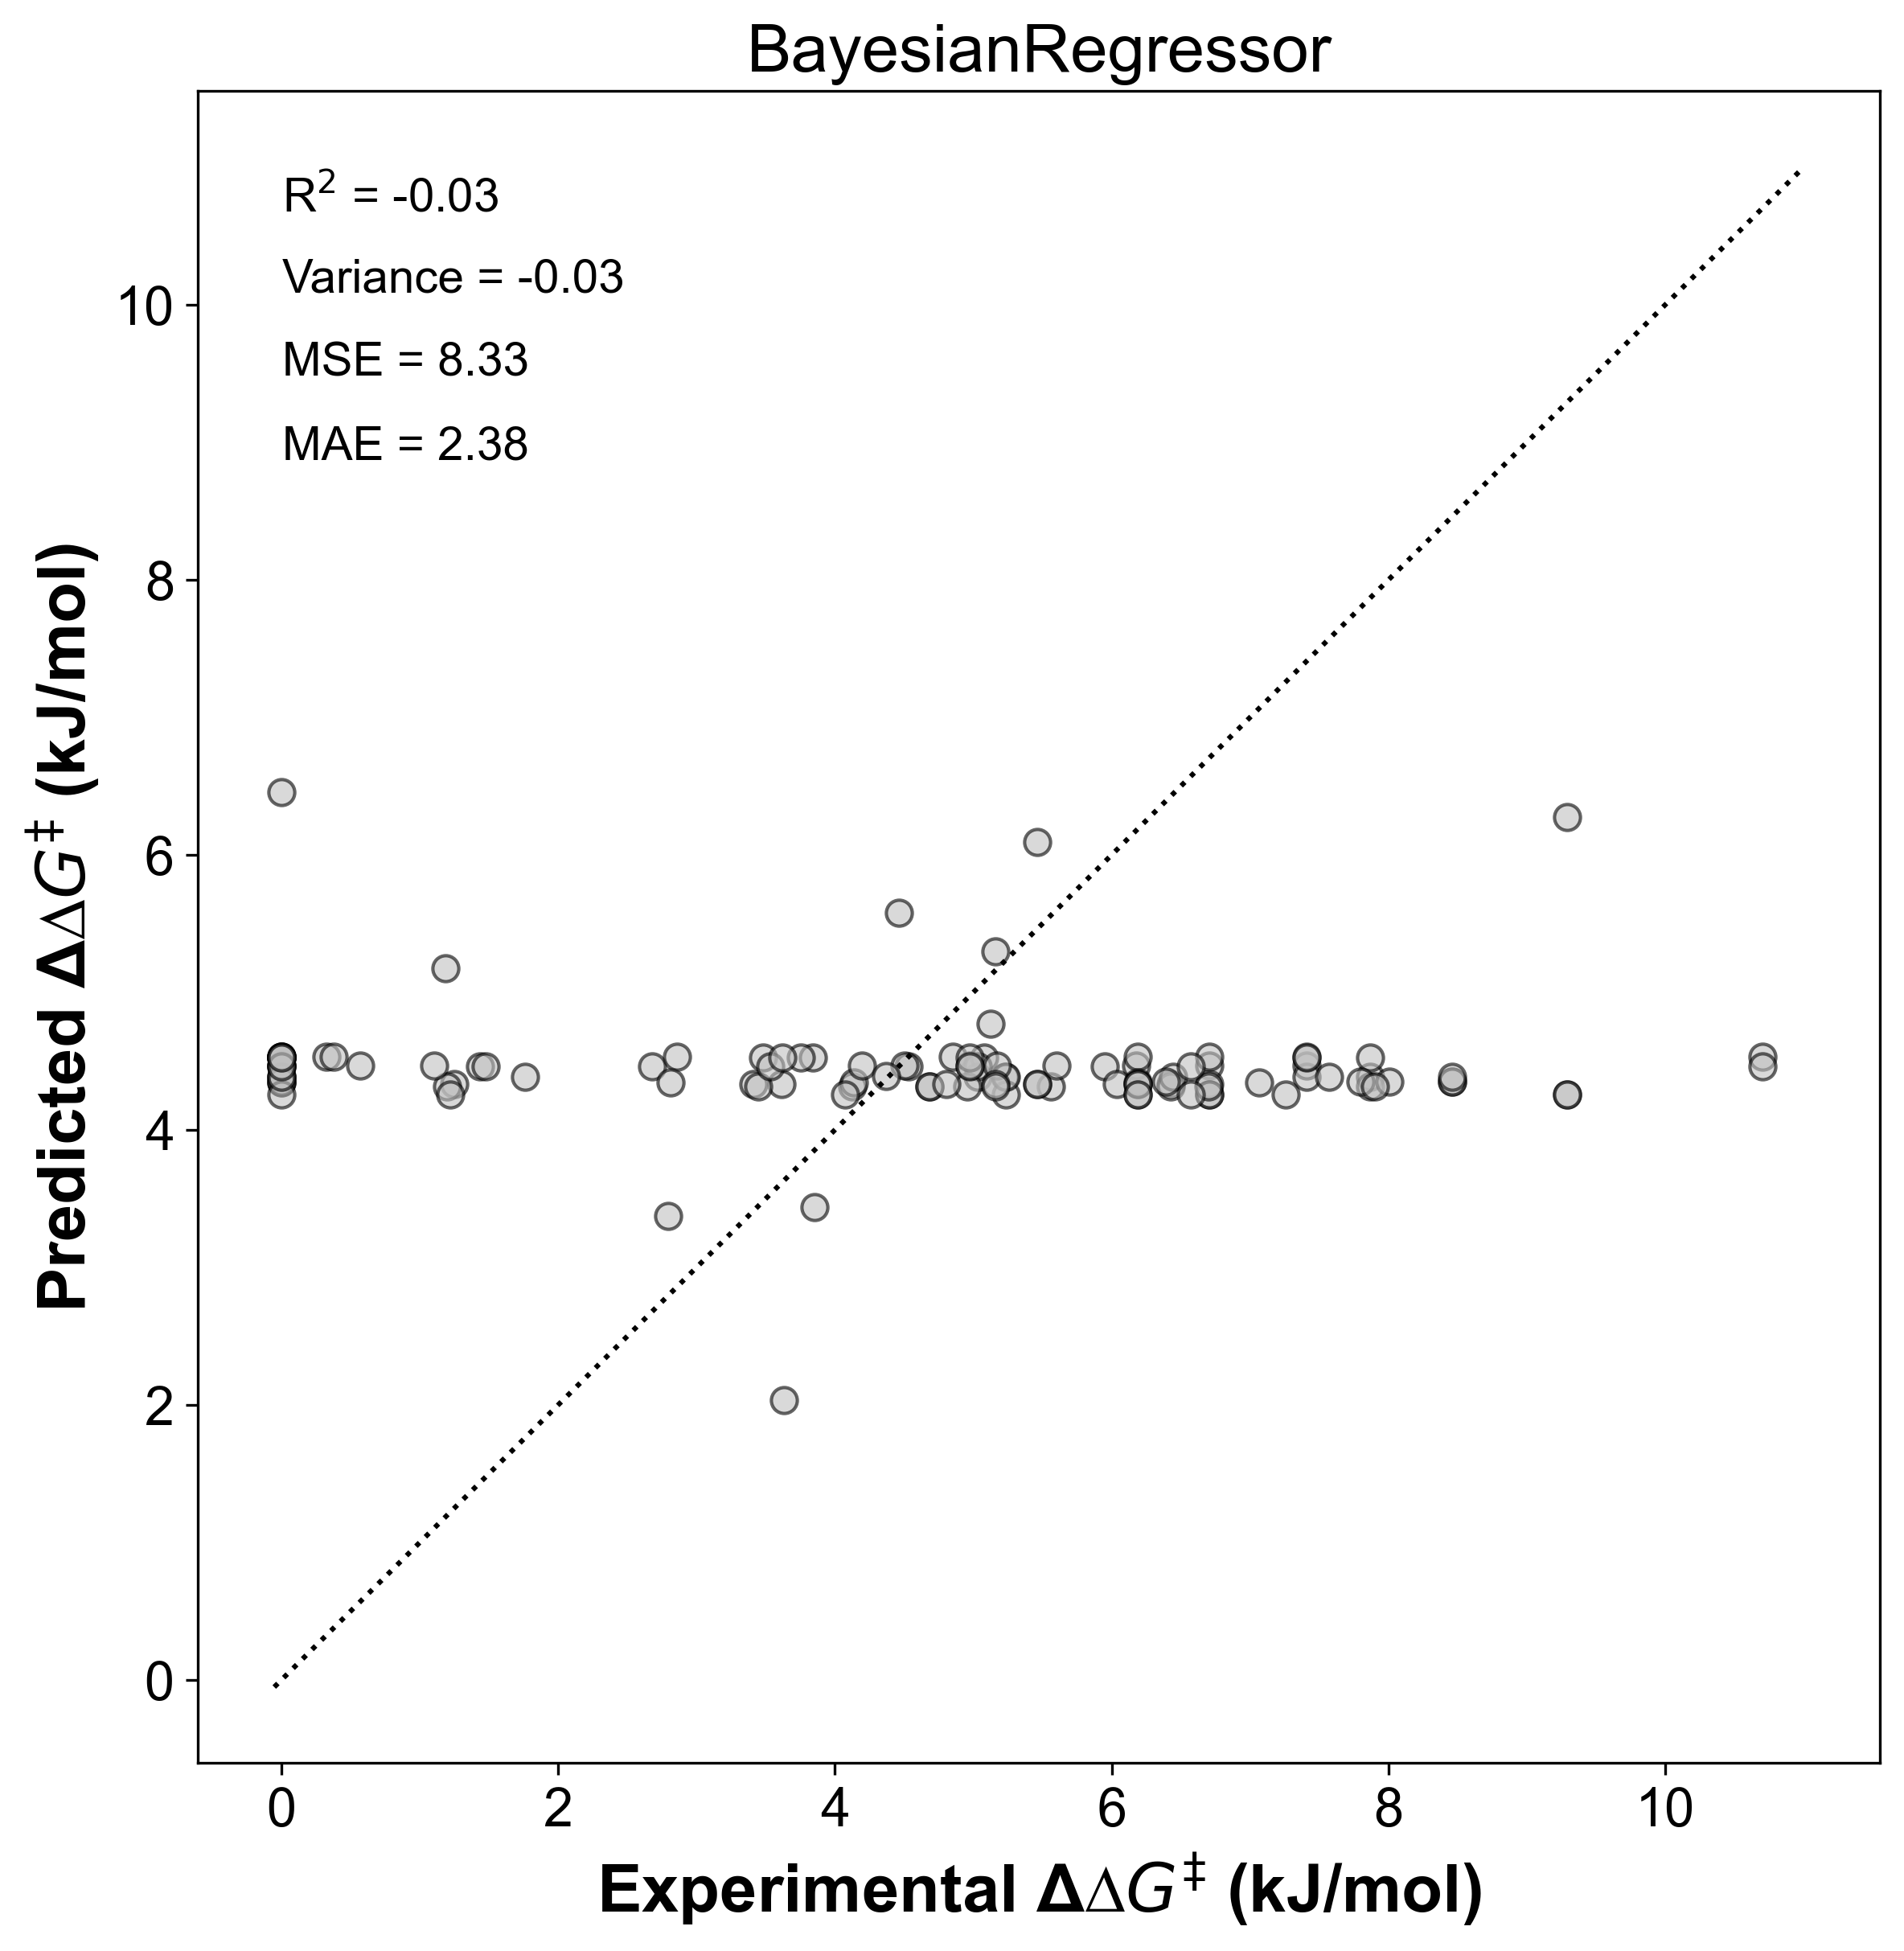

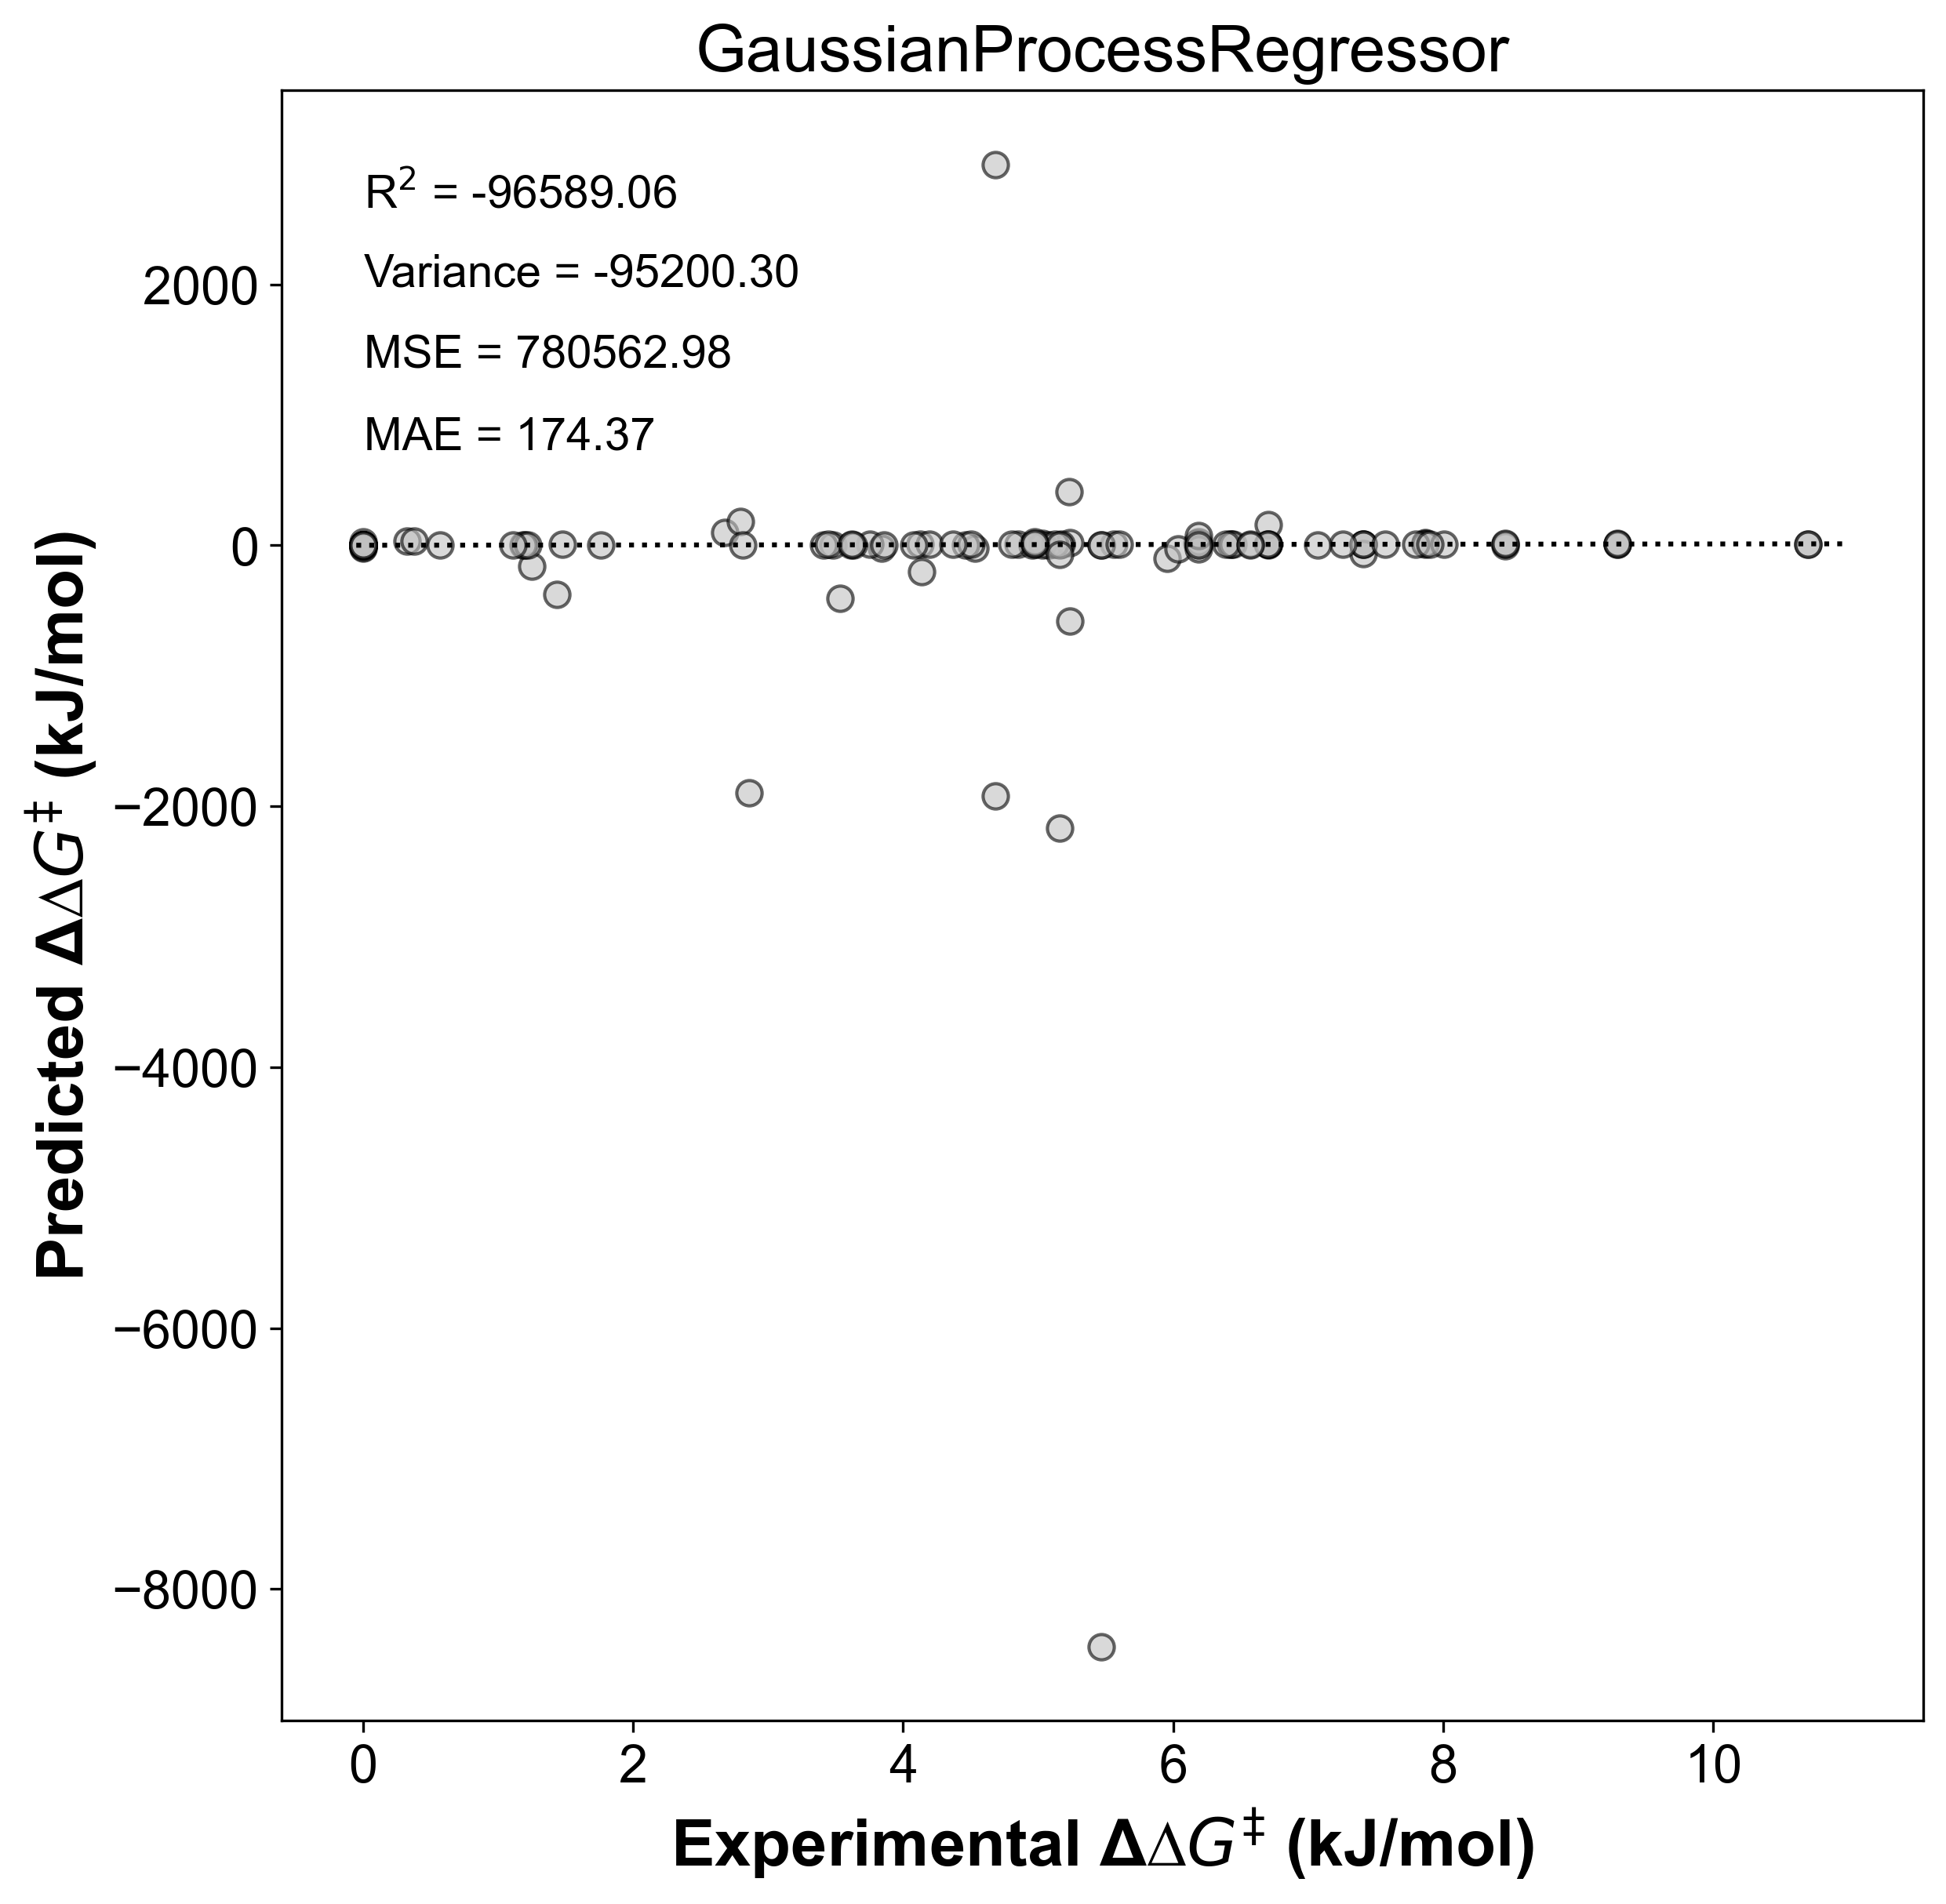

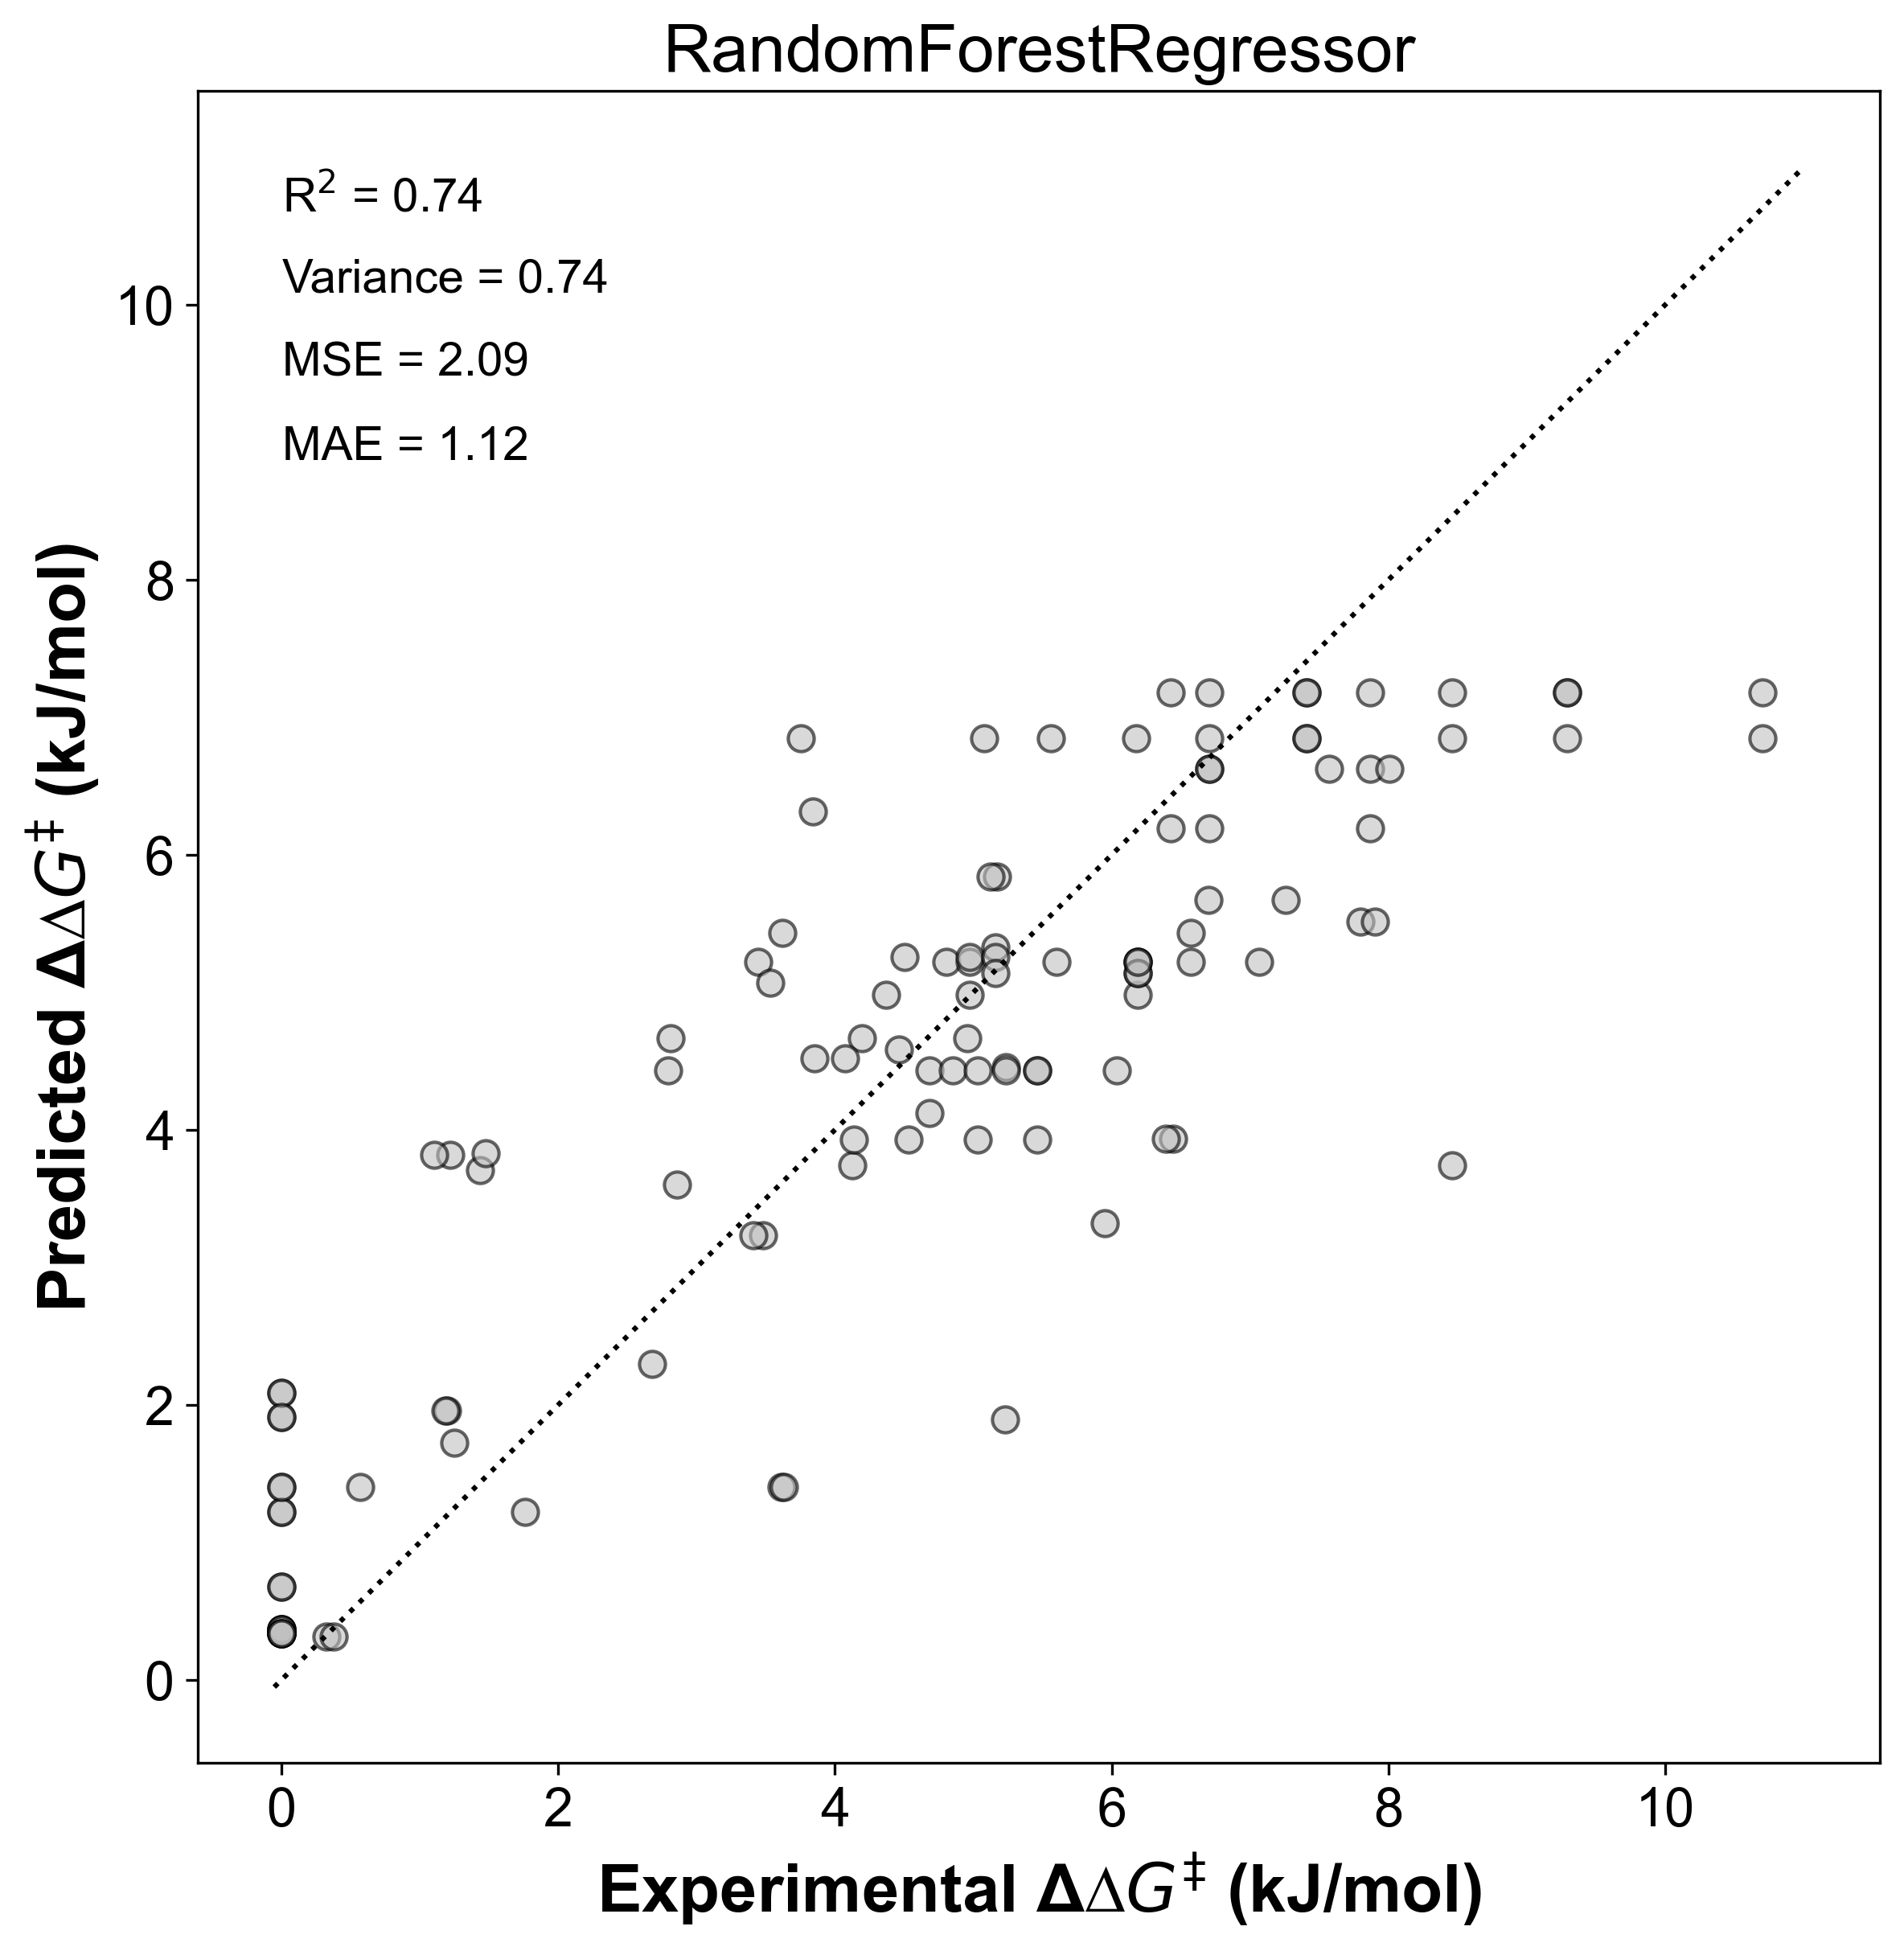

In [17]:
wf.metrics_for_regression(directories=directory_names)

Before you continue please take a moment to look at your results! If you continue blindly, some of the results might be overwritten by the following cells

# LASSOCV Example

Here I show you how to extract important descriptors from LASSO. LASSO uses the L1 regularization term that shrinks features to 0. If you dont know about LASSO read here https://en.wikipedia.org/wiki/Lasso_(statistics)

We need to import again our data (DFT descriptors and DDG target values) as we have made changes on the firstly imported data. Remember we have changed directories!

In [18]:
data = pd.read_csv("../DFTdata.csv",header=None)
ddg = pd.read_csv("../DDG.csv",header=None)
ddg = ddg[0]

In [19]:
Coefficients,Feats = [],[]

X = pd.read_csv("../DFTdata.csv",header=None)
Y = pd.read_csv("../DDG.csv",header=None)
Y=Y[0]

X = scaling.minmaxscale(X)

model=LassoCV(cv=10,selection='random',fit_intercept=True, max_iter=100000000).fit(X,Y)

#Training set
predicted=model.predict(X)

print('Root Mean Squared Error Training Set:', np.sqrt(metrics.mean_squared_error(Y, predicted)))
print('R2 Training Set:',r2_score(Y, predicted))


#Coefficients
log.info("\n-----\nCoefficients\n-----\n")
log.info(model.coef_)
print(len(model.coef_))
for i in range (len(model.coef_)):
    Coefficients.append(model.coef_[i])
    log.info(model.coef_[i])
Feat1=np.nonzero(model.coef_)
Feats.append(Feat1)
log.info(Feat1)
# X2=X[:,Feat1]
# X2.shape
print(model.intercept_)


-----
Coefficients
-----

[ 0.         -1.96833222  0.         -0.          0.24395492  2.10643238
  0.          0.27043222 -1.33514226  0.         -0.          1.0000703
 -0.         -0.          0.         -0.         -0.         -0.
  0.         -0.         -1.38891199  0.          0.          2.62723457
  0.          2.58802785 -0.08751037  3.69323815 -0.         -0.
  0.         -0.75373264 -2.19381708  0.         -0.7903992  -0.
 -2.723493   -1.94716353  0.         -0.          0.          6.83546864
 -0.          0.        ]
0.0
-1.9683322194345154
0.0
-0.0
0.2439549220078801
2.1064323788359833
0.0
0.2704322179403347
-1.3351422550411312
0.0
-0.0
1.0000703049631934
-0.0
-0.0
0.0
-0.0
-0.0
-0.0
0.0
-0.0
-1.3889119858278098
0.0
0.0
2.6272345693438366
0.0
2.588027854963056
-0.08751036830155609
3.6932381462765975
-0.0
-0.0
0.0
-0.7537326364161048
-2.1938170797037726
0.0
-0.7903992009240384
-0.0
-2.7234929983808533
-1.947163532233251
0.0
-0.0
0.0
6.835468642817436
-0.0
0.0
(array([ 1

Root Mean Squared Error Training Set: 1.235672870402969
R2 Training Set: 0.8110566873424441
44
1.2258544976783887


# Now first we split 90%-10% (train-test)

We need to evaluate the performace of our model on an external test set. We know which data points we are using for test set, for consistency reasons. However if you have much more data and you dont know which ones you want to use as a training set, or you don't want to write them manually you could do something like this:

import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.DataFrame(data)

X = df.drop('target', axis=1) y = df['target']

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print("X_test:") print(X_test)

print("y_test:") print(y_test)

In [20]:
data = pd.read_csv("../DFTdata.csv", header = None)

In [21]:
test_reactions = [21, 81, 11, 104, 44, 106, 54, 95, 115, 25, 57, 52]

In [22]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

In [23]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [24]:
ddg = pd.read_csv("../DDG.csv", header = None)
ddg = ddg[0]

In [25]:
ddg_train = ddg.drop(labels =test_reactions, axis=0,inplace = False)

In [26]:
ddg_test = ddg.iloc[test_reactions]

# Define Xtrain, Xtest, Ytrain, Ytest


In [27]:
Xtrain = train_data
Xtest = test_data
Ytrain = ddg_train
Ytest = ddg_test

# Time for ML


In [28]:
# Feel free to add or remove regressors you might want (or don't) to explore, here we just offer some examples.

kfold_reg_names = ["LassoCV","KNeighborsRegressor", "DecisionTreeRegressor", "SVR",
                   "BayesianRegr", "GaussianProcessRegressor", "RandomForestRegressor"]
kfold_regressors = [
    LassoCV(random_state=random_seed, cv=10,selection='random',max_iter=1000000),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=random_seed),
    svm.SVR(), #SVR takes some time be patient if you are not, comment it out
    linear_model.BayesianRidge(n_iter=100000),
    GaussianProcessRegressor(),
    RandomForestRegressor(random_state=random_seed)]# takes some time, you can remove some options for the parameters

kfold_regressors_parameters = {
    "LassoCV":{},
    "KNeighborsRegressor": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "DecisionTreeRegressor": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "SVR": {"kernel":['linear', 'poly', 'rbf'], "degree":[2,3], "gamma":['auto','scale'], "coef0":[0,1], 'C':[100]},    
    "BayesianRegr":{'alpha_1':[1e-06, 10], 'alpha_2': [1e-06,10],'lambda_1':[1e-06,10], 'lambda_2': [1e-06,10]},
    "GaussianProcessRegressor": {},  
    "RandomForestRegressor":{'n_estimators': [10,20],'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'],'max_depth': [3, 4, 5, 7, 10],
    'max_features': ['auto','sqrt','log2'],'bootstrap': [True, False],'warm_start': [True, False]}
}

In [29]:
%%capture
wf.split_test_regressors_with_optimization(Xtrain,Ytrain,Xtest,Ytest, kfold_regressors, kfold_regressors_parameters, scale=True, cv=5, n_repeats=10, rgs_names=kfold_reg_names)

Starting regression

-----
Begin LassoCV
-----

Directory LassoCV already exists will be overwritten
	name: LassoCV parameters: {}

	 The predictions are: [ 7.06864875  5.84375147  6.20301128  1.21327281  4.31514273 -0.14410961
  6.38040521  5.03016723 -0.43939191  6.9028231   2.32644032  6.05236158]
{'name': 'LassoCV', 'variance': 0.83, 'MAE': 0.9, 'MSE': 1.37, 'RMSE': 1.1704699910719625, 'R2': 0.83}
{'name': 'LassoCV', 'variance': 0.8, 'MAE': 1.24, 'MSE': 1.84, 'RMSE': 1.3564659966250536, 'R2': 0.79}

-----
Begin KNeighborsRegressor
-----

Directory KNeighborsRegressor already exists will be overwritten
	name: KNeighborsRegressor parameters: {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}

	 The predictions are: [6.76444045 5.72385103 6.60503346 0.         4.01118104 0.
 6.5420664  5.30267527 0.30543197 6.31439796 2.58695033 6.60503346]
{'name': 'KNeighborsRegressor', 'variance': 0.84, 'MAE': 0.84, 'MSE': 1.34, 'RMSE': 1.1575836902790226, 'R2': 0.83}
{'name': 'KNeighborsRegressor', 'varian